In [5]:
from pathlib import Path
import numpy as np
import pandas as pd

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi

### Configurations

In [6]:
DATA_DIR = Path("data")
OUT_DIR  = Path("outputs")
(OUT_DIR / "base").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "shape").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "space").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "qualitative").mkdir(parents=True, exist_ok=True)

REAL_DIR = DATA_DIR / "real"
GEN_DIR  = DATA_DIR / "generated"

MIN_REGION_AREA_RATIO = 0.002   # 0.2%
EDGE_CLOSE_K = 3                # morphological close kernel size
CANNY_LOW, CANNY_HIGH = 60, 160

### Helper Functions

In [8]:
import cv2

def imread_rgb(path: Path):
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def remove_tiny_objects(binary_mask, min_size=64):
    # scikit-image >= 0.26 warns about min_size; older versions may not support max_size
    try:
        return remove_small_objects(binary_mask, max_size=min_size-1)
    except TypeError:
        return remove_small_objects(binary_mask, min_size=min_size)

def to_gray(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def normalize01(x, eps=1e-9):
    x = x.astype(np.float32)
    mn, mx = np.min(x), np.max(x)
    return (x - mn) / (mx - mn + eps)

# --- Step 2.1: multi-scale edge map
def edge_map_multiscale(gray):
    # --- ensure uint8 for Canny ---
    g0 = np.asarray(gray)
    if g0.dtype != np.uint8:
        g0 = np.clip(g0, 0, 1) if g0.max() <= 1.5 else np.clip(g0, 0, 255)
        g0 = (g0 * 255.0).astype(np.uint8) if g0.max() <= 1.5 else g0.astype(np.uint8)

    edges_all = []
    for sigma in [0.8, 1.6, 3.2]:
        g = cv2.GaussianBlur(g0, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
        e = cv2.Canny(g, CANNY_LOW, CANNY_HIGH)
        edges_all.append(e > 0)

    E = np.logical_or.reduce(edges_all)

    # (keep your cleanup steps here)
    return E.astype(np.uint8)

# --- Step 2.2: saliency (OpenCV spectral residual)
def saliency_map(gray):
    sal = cv2.saliency.StaticSaliencySpectralResidual_create()
    ok, sm = sal.computeSaliency(gray)
    if not ok:
        # fallback: contrast-based
        sm = cv2.Laplacian(gray, cv2.CV_32F)
        sm = np.abs(sm)
    return normalize01(sm)

# --- Step 3: regions via watershed from edges
def region_map_from_edges(gray, edge_bin):
    # treat edges as barriers, watershed on distance in non-edge space
    non_edge = (edge_bin == 0).astype(np.uint8)
    dist = cv2.distanceTransform(non_edge, distanceType=cv2.DIST_L2, maskSize=3)
    dist = dist.astype(np.float32)

    # peaks as markers
    coords = peak_local_max(dist, min_distance=12, threshold_abs=np.percentile(dist, 70))
    markers = np.zeros(gray.shape, dtype=np.int32)
    for i, (r,c) in enumerate(coords, start=1):
        markers[r,c] = i
    markers = ndi.label(markers > 0)[0].astype(np.int32)

    labels = watershed(-dist, markers, mask=non_edge.astype(bool))
    return labels.astype(np.int32)

def filter_small_regions(labels, min_area_px):
    out = labels.copy()
    # relabel to contiguous ids after filtering
    ids = np.unique(out)
    ids = ids[ids != 0]
    keep = []
    for rid in ids:
        area = int(np.sum(out == rid))
        if area >= min_area_px:
            keep.append(rid)
        else:
            out[out == rid] = 0
    # compact relabel
    new = np.zeros_like(out, dtype=np.int32)
    nid = 1
    for rid in keep:
        new[out == rid] = nid
        nid += 1
    return new

# --- Step 4: basic region features (we’ll expand later)
def region_features_basic(labels, saliency01):
    H, W = labels.shape
    img_area = H * W
    feats = []
    ids = np.unique(labels)
    ids = ids[ids != 0]
    for rid in ids:
        mask = (labels == rid)
        area_px = int(mask.sum())
        area_ratio = area_px / img_area
        mean_sal = float(np.mean(saliency01[mask])) if area_px else 0.0
        feats.append({
            "region_id": int(rid),
            "area_px": area_px,
            "area_ratio": area_ratio,
            "saliency_mean": mean_sal,
        })
    return pd.DataFrame(feats)

def image_shape_indices_from_regions(df_r):
    # very simple first-pass indices (we’ll replace with your full ones)
    if df_r.empty:
        return dict(n_regions=0, total_saliency=np.nan, hierarchy_concentration_top1=np.nan, mean_area_ratio=np.nan)

    n_regions = int(len(df_r))
    total_saliency = float(df_r["saliency_mean"].sum())
    top1 = float(df_r["saliency_mean"].max())
    conc_top1 = float(top1 / (total_saliency + 1e-9))
    mean_area_ratio = float(df_r["area_ratio"].mean())
    return dict(
        n_regions=n_regions,
        total_saliency=total_saliency,
        hierarchy_concentration_top1=conc_top1,
        mean_area_ratio=mean_area_ratio
    )

# %% Step 1: manifest
def build_manifest():
    rows = []
    for split, folder in [("real", REAL_DIR), ("generated", GEN_DIR)]:
        if not folder.exists():
            continue
        for p in sorted(folder.rglob("*")):
            if p.suffix.lower() not in [".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tif", ".tiff"]:
                continue
            rgb = imread_rgb(p)
            H, W = rgb.shape[:2]
            rel = p.relative_to(DATA_DIR).as_posix()
            rows.append({"split": split, "image_id": rel, "H": H, "W": W})
    df = pd.DataFrame(rows)
    df.to_csv(OUT_DIR / "base" / "image_manifest.csv", index=False)
    return df

# %% Run base pipeline
df_manifest = build_manifest()
print("Images:", len(df_manifest))

all_region_rows = []
all_image_rows  = []

for _, row in df_manifest.iterrows():
    split = row["split"]
    image_id = row["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path)
    gray = to_gray(rgb)

    edges = edge_map_multiscale(gray)
    sal01 = saliency_map(gray)
    labels = region_map_from_edges(gray, edges)

    H, W = gray.shape
    min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
    labels = filter_small_regions(labels, min_area_px=min_area_px)

    df_r = region_features_basic(labels, sal01)
    df_r.insert(0, "split", split)
    df_r.insert(1, "image_id", image_id)
    all_region_rows.append(df_r)

    img_idx = image_shape_indices_from_regions(df_r)
    img_idx.update({"split": split, "image_id": image_id})
    all_image_rows.append(img_idx)

df_regions = pd.concat(all_region_rows, ignore_index=True) if all_region_rows else pd.DataFrame()
df_images  = pd.DataFrame(all_image_rows)

df_regions.to_csv(OUT_DIR / "shape" / "region_features.csv", index=False)
df_images.to_csv(OUT_DIR / "shape" / "image_shape_indices.csv", index=False)

print("Saved:",
      OUT_DIR / "shape" / "region_features.csv",
      OUT_DIR / "shape" / "image_shape_indices.csv")
print("df_regions:", df_regions.shape)
print("df_images :", df_images.shape)


Images: 130
Saved: outputs\shape\region_features.csv outputs\shape\image_shape_indices.csv
df_regions: (2315, 6)
df_images : (130, 6)


### Segmentation-boundary T-junctions → occlusion edges → DAG summary

In [9]:
import math
import networkx as nx
from skimage.measure import label as cc_label, regionprops

SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

### Helper Functions

In [10]:
def pca_orientation(points_rc):
    """
    points_rc: (N,2) array of (r,c)
    returns: angle_rad in image coords (x=c, y=r), eig_ratio, n_points
    """
    pts = np.asarray(points_rc, dtype=np.float32)
    n = len(pts)
    if n < 10:
        return None, 0.0, n
    # center
    mu = pts.mean(axis=0, keepdims=True)
    X = pts - mu
    # covariance
    C = (X.T @ X) / max(n - 1, 1)
    # eig
    w, v = np.linalg.eigh(C)
    # sort desc
    idx = np.argsort(w)[::-1]
    w = w[idx]; v = v[:, idx]
    if w[1] <= 1e-9:
        eig_ratio = 1e6
    else:
        eig_ratio = float(w[0] / (w[1] + 1e-9))
    # principal direction vector (in r,c space)
    dr, dc = float(v[0,0]), float(v[1,0])
    # convert to angle in x-y: x=dc, y=dr
    angle = math.atan2(dr, dc)  # radians
    return angle, eig_ratio, n

def angle_diff(a, b):
    """smallest absolute difference between two angles (radians), modulo pi (undirected line)."""
    if a is None or b is None:
        return math.pi
    # lines are undirected => wrap by pi
    d = abs(a - b) % math.pi
    return min(d, math.pi - d)

def boundary_mask_from_labels(labels):
    """pixels that touch a different label in 8-neighborhood"""
    L = labels
    H, W = L.shape
    bm = np.zeros((H,W), dtype=bool)
    for dr in [-1,0,1]:
        for dc in [-1,0,1]:
            if dr == 0 and dc == 0:
                continue
            shifted = np.roll(np.roll(L, dr, axis=0), dc, axis=1)
            bm |= (shifted != L)
    bm &= (L != 0)
    return bm

def junction_candidates(labels, win=1):
    """
    Candidate junction pixels: boundary pixels where >=3 unique region ids occur in (2*win+1)^2 window.
    """
    bm = boundary_mask_from_labels(labels)
    H, W = labels.shape
    cand = np.zeros((H,W), dtype=bool)
    for r in range(win, H-win):
        for c in range(win, W-win):
            if not bm[r,c]:
                continue
            patch = labels[r-win:r+win+1, c-win:c+win+1]
            u = np.unique(patch)
            u = u[u != 0]
            if len(u) >= 3:
                cand[r,c] = True
    return cand

def compress_candidates_to_points(cand_mask):
    """
    Many pixels light up around one junction; compress via connected components and take centroid.
    """
    lab = cc_label(cand_mask.astype(np.uint8), connectivity=2)
    pts = []
    for rp in regionprops(lab):
        rr, cc = rp.coords[:,0], rp.coords[:,1]
        r0 = int(np.round(rr.mean()))
        c0 = int(np.round(cc.mean()))
        pts.append((r0, c0, int(rp.area)))
    return pts

def region_border_pixels(labels, rid):
    """boundary pixels belonging to region rid (touch different label)"""
    mask = (labels == rid)
    if not mask.any():
        return np.zeros_like(labels, dtype=bool)
    bm = boundary_mask_from_labels(labels)
    return bm & mask

def region_contour_metrics(labels, rid):
    """
    Convexity proxy + closure proxy from contour:
    - convexity = area / convexHullArea
    - closure = 4*pi*A / P^2   (1=perfect circle; lower = jagged/open)
    """
    mask = (labels == rid).astype(np.uint8)
    if mask.sum() < 10:
        return 0.0, 0.0, 0.0, 0.0

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, 0.0, 0.0, 0.0

    cnt = max(contours, key=cv2.contourArea)
    area = float(cv2.contourArea(cnt))
    perim = float(cv2.arcLength(cnt, True))

    hull = cv2.convexHull(cnt)
    hull_area = float(cv2.contourArea(hull)) if hull is not None else 0.0

    convexity = float(area / (hull_area + 1e-9))
    closure = float((4.0 * math.pi * area) / ((perim * perim) + 1e-9))
    return area, perim, convexity, closure

def zscore_dict(vals_dict, eps=1e-9):
    """z-score a dict of {id: value} over ids"""
    ids = list(vals_dict.keys())
    x = np.array([vals_dict[i] for i in ids], dtype=np.float32)
    mu = float(np.mean(x)) if len(x) else 0.0
    sd = float(np.std(x)) if len(x) else 1.0
    sd = sd if sd > eps else 1.0
    return {i: float((vals_dict[i] - mu) / sd) for i in ids}

def break_cycles_by_min_weight(G: nx.DiGraph):
    """
    Remove minimum-weight edges from cycles until acyclic.
    Returns removed edges list.
    """
    removed = []
    while True:
        try:
            cyc = next(nx.simple_cycles(G))
        except StopIteration:
            break
        # find weakest edge on this directed cycle
        weakest = None
        weakest_w = float("inf")
        for u, v in zip(cyc, cyc[1:] + [cyc[0]]):
            w = float(G[u][v].get("weight", 0.0))
            if w < weakest_w:
                weakest_w = w
                weakest = (u, v)
        if weakest is None:
            break
        u, v = weakest
        removed.append((u, v, weakest_w))
        G.remove_edge(u, v)
    return removed

def region_mask_features(mask):
    # mask: bool
    m = mask.astype(np.uint8) * 255
    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return {"solidity": 0.0, "circularity": 0.0, "n_components": 0}
    c = max(cnts, key=cv2.contourArea)
    area = float(cv2.contourArea(c)) + 1e-9
    perim = float(cv2.arcLength(c, True)) + 1e-9

    hull = cv2.convexHull(c)
    hull_area = float(cv2.contourArea(hull)) + 1e-9
    solidity = float(area / hull_area)

    circularity = float(4.0 * math.pi * area / (perim * perim))  # 1=perfect circle

    # component count (quick)
    nlab, _ = cv2.connectedComponents((mask > 0).astype(np.uint8))
    n_components = int(nlab - 1)

    return {"solidity": solidity, "circularity": circularity, "n_components": n_components}

def geo_overlap_simplicity(mask):
    f = region_mask_features(mask)
    # overlap patch should be: mostly one component + reasonably solid + not super jagged
    comp_pen = math.exp(-max(f["n_components"] - 1, 0))
    score = (0.65 * f["solidity"] + 0.35 * f["circularity"]) * comp_pen
    return float(np.clip(score, 0.0, 1.0))

### Batch Run

In [11]:
junction_rows = []
edge_rows = []
summary_rows = []

for _, row in df_manifest.iterrows():
    split = row["split"]
    image_id = row["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path)
    gray = to_gray(rgb)


    edges = edge_map_multiscale(gray)
    sal01  = saliency_map(gray)
    labels = region_map_from_edges(gray, edges)

    H, W = gray.shape
    min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
    labels = filter_small_regions(labels, min_area_px=min_area_px)

    region_ids = np.unique(labels)
    region_ids = region_ids[region_ids != 0]
    if len(region_ids) < 3:
        summary_rows.append({
            "split": split, "image_id": image_id,
            "n_regions": int(len(region_ids)),
            "n_junctions": 0,
            "n_edges_raw": 0,
            "n_edges_dag": 0,
            "n_cycles_removed": 0,
        })
        continue

    # --- Border ownership proxy components per region
    # saliency mean inside region
    sal_mean = {}
    convexity = {}
    closure = {}
    for rid in region_ids:
        m = (labels == rid)
        sal_mean[int(rid)] = float(np.mean(sal01[m])) if m.any() else 0.0
        _, _, conv, clo = region_contour_metrics(labels, int(rid))
        convexity[int(rid)] = conv
        closure[int(rid)] = clo

    # z-score within image for comparability
    z_sal = zscore_dict(sal_mean)
    z_conv = zscore_dict(convexity)
    z_clo = zscore_dict(closure)

    # figure probability proxy (0..1-ish via sigmoid)
    fig_score = {}
    for rid in region_ids:
        z = 0.6 * z_sal[int(rid)] + 0.25 * z_conv[int(rid)] + 0.15 * z_clo[int(rid)]
        fig_score[int(rid)] = float(1.0 / (1.0 + math.exp(-z)))

    # --- Junction candidates
    cand = junction_candidates(labels, win=1)  # 3x3 neighborhood
    pts = compress_candidates_to_points(cand)

    # --- Build directed multigraph edges from junctions
    Gm = nx.MultiDiGraph()

    for (jr, jc, area_px) in pts:
        win = 9  # analysis window radius (tune if needed)
        r0, r1 = max(0, jr-win), min(H, jr+win+1)
        c0, c1 = max(0, jc-win), min(W, jc+win+1)
        patch = labels[r0:r1, c0:c1]

        u = np.unique(patch)
        u = u[u != 0]
        if len(u) < 3:
            continue

        # take top-3 most frequent ids in patch (robust if noisy)
        counts = [(int(rid), int(np.sum(patch == rid))) for rid in u]
        counts.sort(key=lambda x: x[1], reverse=True)
        ids3 = [counts[0][0], counts[1][0], counts[2][0]]
        a, b, c = ids3

        # For each pair, gather boundary pixels (within patch) where labels are that pair
        pairs = [(a,b), (a,c), (b,c)]
        pair_info = []
        for (rX, rY) in pairs:
            # boundary pixels where label is either rX or rY AND touches the other
            sub = patch.copy()
            maskXY = np.isin(sub, [rX, rY])
            if not maskXY.any():
                pair_info.append(((rX,rY), None, 0.0, 0))
                continue

            # compute boundary within patch (local)
            bmask = np.zeros_like(sub, dtype=bool)
            for dr in [-1,0,1]:
                for dc in [-1,0,1]:
                    if dr == 0 and dc == 0:
                        continue
                    sh = np.roll(np.roll(sub, dr, axis=0), dc, axis=1)
                    bmask |= (sh != sub)
            bmask &= maskXY

            coords = np.column_stack(np.where(bmask))
            ang, eig_ratio, npts = pca_orientation(coords)
            # score: support * linearity
            score = float(npts * np.log1p(eig_ratio))
            pair_info.append(((rX,rY), ang, score, npts))

        # choose "bar pair" = max score (straight + supported)
        pair_info.sort(key=lambda x: x[2], reverse=True)
        (bar_pair, bar_ang, bar_score, bar_n) = pair_info[0]
        (p2, ang2, s2, n2) = pair_info[1]
        (p3, ang3, s3, n3) = pair_info[2]

        # stem region is the id not in bar_pair
        stem_region = [rid for rid in ids3 if rid not in bar_pair]
        if len(stem_region) != 1:
            continue
        stem_region = stem_region[0]
        bar_r1, bar_r2 = bar_pair

        # confidence: bar dominance + bar straightness
        straight_bonus = float(np.tanh((bar_score / (s2 + 1e-9)) * 0.5))
        conf = float(np.clip(straight_bonus, 0.0, 1.0))

        # record junction
        junction_rows.append({
            "split": split, "image_id": image_id,
            "x": int(jc), "y": int(jr),
            "region_a": a, "region_b": b, "region_c": c,
            "bar_r1": int(bar_r1), "bar_r2": int(bar_r2),
            "stem_region": int(stem_region),
            "bar_score": float(bar_score),
            "confidence": conf,
            "cand_area_px": int(area_px),
        })

        # Border ownership proxy: distribute occlusion from the two bar regions toward the stem region
        p1 = fig_score.get(int(bar_r1), 0.5)
        p2 = fig_score.get(int(bar_r2), 0.5)
        denom = (p1 + p2 + 1e-9)
        w1 = conf * (p1 / denom)
        w2 = conf * (p2 / denom)

        # add multiedges (evidence = tjunction)
        Gm.add_edge(int(bar_r1), int(stem_region), weight=float(w1), evidence="tjunction")
        Gm.add_edge(int(bar_r2), int(stem_region), weight=float(w2), evidence="tjunction")

        edge_rows.append({
            "split": split, "image_id": image_id,
            "src_region": int(bar_r1), "dst_region": int(stem_region),
            "weight": float(w1), "evidence": "tjunction",
            "junction_x": int(jc), "junction_y": int(jr),
            "confidence": conf
        })
        edge_rows.append({
            "split": split, "image_id": image_id,
            "src_region": int(bar_r2), "dst_region": int(stem_region),
            "weight": float(w2), "evidence": "tjunction",
            "junction_x": int(jc), "junction_y": int(jr),
            "confidence": conf
        })

    # --- Collapse MultiDiGraph to DiGraph by max weight per (u,v)
    G = nx.DiGraph()
    for u, v, data in Gm.edges(data=True):
        w = float(data.get("weight", 0.0))
        if G.has_edge(u, v):
            if w > G[u][v]["weight"]:
                G[u][v]["weight"] = w
                G[u][v]["evidence"] = data.get("evidence", "tjunction")
        else:
            G.add_edge(u, v, weight=w, evidence=data.get("evidence", "tjunction"))

    n_edges_raw = G.number_of_edges()

    # --- Enforce DAG by removing weakest edges in cycles
    removed = break_cycles_by_min_weight(G)
    n_removed = len(removed)
    n_edges_dag = G.number_of_edges()

    summary_rows.append({
        "split": split, "image_id": image_id,
        "n_regions": int(len(region_ids)),
        "n_junctions": int(sum(1 for r in junction_rows if r["split"]==split and r["image_id"]==image_id)),
        "n_edges_raw": int(n_edges_raw),
        "n_edges_dag": int(n_edges_dag),
        "n_cycles_removed": int(n_removed),
        "total_removed_weight": float(sum(w for _,_,w in removed)) if removed else 0.0,
    })

# Save outputs
df_junc = pd.DataFrame(junction_rows)
df_edges = pd.DataFrame(edge_rows)
df_sum = pd.DataFrame(summary_rows)

df_junc.to_csv(SPACE_DIR / "junctions.csv", index=False)
df_edges.to_csv(SPACE_DIR / "ownership_edges.csv", index=False)
df_sum.to_csv(SPACE_DIR / "depth_graph_summary.csv", index=False)

print("Saved:",
      SPACE_DIR / "junctions.csv",
      SPACE_DIR / "ownership_edges.csv",
      SPACE_DIR / "depth_graph_summary.csv")
print("junctions:", df_junc.shape, "edges:", df_edges.shape, "summary:", df_sum.shape)

Saved: outputs\space\junctions.csv outputs\space\ownership_edges.csv outputs\space\depth_graph_summary.csv
junctions: (463, 13) edges: (926, 9) summary: (130, 8)


### Depth-Relief Graph (DAG + uncertainty + depth levels)

In [12]:
import math
import numpy as np
import pandas as pd
import cv2
import networkx as nx
from skimage.measure import label as cc_label, regionprops
from skimage.morphology import remove_small_objects


SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

### Angle Helpers

In [13]:
def angle_diff_undirected(a, b):
    """
    smallest difference between two undirected line angles (radians), modulo pi
    in [0, pi/2]
    """
    if a is None or b is None:
        return math.pi / 2
    d = abs(a - b) % math.pi
    d = min(d, math.pi - d)
    return min(d, math.pi/2)

def pca_orientation(points_rc):
    pts = np.asarray(points_rc, dtype=np.float32)
    n = len(pts)
    if n < 10:
        return None, 0.0, n
    mu = pts.mean(axis=0, keepdims=True)
    X = pts - mu
    C = (X.T @ X) / max(n - 1, 1)
    w, v = np.linalg.eigh(C)
    idx = np.argsort(w)[::-1]
    w = w[idx]; v = v[:, idx]
    eig_ratio = float(w[0] / (w[1] + 1e-9)) if w[1] > 1e-12 else 1e6
    dr, dc = float(v[0,0]), float(v[1,0])
    ang = math.atan2(dr, dc)  # x=dc, y=dr
    return ang, eig_ratio, n

def boundary_mask_from_labels(labels):
    L = labels
    H, W = L.shape
    bm = np.zeros((H,W), dtype=bool)
    for dr in [-1,0,1]:
        for dc in [-1,0,1]:
            if dr == 0 and dc == 0:
                continue
            shifted = np.roll(np.roll(L, dr, axis=0), dc, axis=1)
            bm |= (shifted != L)
    bm &= (L != 0)
    return bm

def junction_candidates(labels, win=1):
    bm = boundary_mask_from_labels(labels)
    H, W = labels.shape
    cand = np.zeros((H,W), dtype=bool)
    for r in range(win, H-win):
        for c in range(win, W-win):
            if not bm[r,c]:
                continue
            patch = labels[r-win:r+win+1, c-win:c+win+1]
            u = np.unique(patch); u = u[u != 0]
            if len(u) >= 3:
                cand[r,c] = True
    return cand

def compress_candidates_to_points(cand_mask):
    lab = cc_label(cand_mask.astype(np.uint8), connectivity=2)
    pts = []
    for rp in regionprops(lab):
        rr, cc = rp.coords[:,0], rp.coords[:,1]
        r0 = int(np.round(rr.mean()))
        c0 = int(np.round(cc.mean()))
        pts.append((r0, c0, int(rp.area)))
    return pts

def region_contour_metrics(labels, rid):
    mask = (labels == rid).astype(np.uint8)
    if mask.sum() < 10:
        return 0.0, 0.0, 0.0, 0.0
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0.0, 0.0, 0.0, 0.0
    cnt = max(contours, key=cv2.contourArea)
    area = float(cv2.contourArea(cnt))
    perim = float(cv2.arcLength(cnt, True))
    hull = cv2.convexHull(cnt)
    hull_area = float(cv2.contourArea(hull)) if hull is not None else 0.0
    convexity = float(area / (hull_area + 1e-9))
    closure = float((4.0 * math.pi * area) / ((perim * perim) + 1e-9))
    return area, perim, convexity, closure

def zscore_dict(vals_dict, eps=1e-9):
    ids = list(vals_dict.keys())
    x = np.array([vals_dict[i] for i in ids], dtype=np.float32)
    mu = float(np.mean(x)) if len(x) else 0.0
    sd = float(np.std(x)) if len(x) else 1.0
    sd = sd if sd > eps else 1.0
    return {i: float((vals_dict[i] - mu) / sd) for i in ids}

def break_cycles_by_min_weight(G: nx.DiGraph):
    removed = []
    while True:
        try:
            cyc = next(nx.simple_cycles(G))
        except StopIteration:
            break
        weakest = None; weakest_w = float("inf")
        for u, v in zip(cyc, cyc[1:] + [cyc[0]]):
            w = float(G[u][v].get("weight", 0.0))
            if w < weakest_w:
                weakest_w = w; weakest = (u, v)
        if weakest is None:
            break
        u, v = weakest
        removed.append((u, v, weakest_w))
        G.remove_edge(u, v)
    return removed


In [14]:
def gaussian_score(x, sigma):
    # x in radians
    return float(math.exp(- (x*x) / (2.0 * sigma*sigma + 1e-9)))

# tuning (safe defaults)
SIGMA_COL = math.radians(15)   # stem-bar stem angles should match within ~15°
SIGMA_ORTH = math.radians(20)  # bar ⟂ stem within ~20°

junction_rows = []
edge_rows = []
summary_rows = []

for _, row in df_manifest.iterrows():
    split = row["split"]
    image_id = row["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path)
    gray = to_gray(rgb)
    H, W = gray.shape

    edges = edge_map_multiscale(gray)
    sal01  = saliency_map(gray)
    labels = region_map_from_edges(gray, edges)
    min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
    labels = filter_small_regions(labels, min_area_px=min_area_px)

    region_ids = np.unique(labels); region_ids = region_ids[region_ids != 0]
    if len(region_ids) < 3:
        summary_rows.append({
            "split": split, "image_id": image_id,
            "n_regions": int(len(region_ids)),
            "n_junctions": 0,
            "n_edges_raw": 0,
            "n_edges_dag": 0,
            "n_cycles_removed": 0,
            "total_removed_weight": 0.0
        })
        continue

    # figure score components
    sal_mean = {}
    convexity = {}
    closure = {}
    for rid in region_ids:
        rid = int(rid)
        m = (labels == rid)
        sal_mean[rid] = float(np.mean(sal01[m])) if m.any() else 0.0
        _, _, conv, clo = region_contour_metrics(labels, rid)
        convexity[rid] = conv
        closure[rid] = clo

    z_sal = zscore_dict(sal_mean)
    z_conv = zscore_dict(convexity)
    z_clo = zscore_dict(closure)

    fig_score = {}
    for rid in region_ids:
        rid = int(rid)
        z = 0.6*z_sal[rid] + 0.25*z_conv[rid] + 0.15*z_clo[rid]
        fig_score[rid] = float(1.0 / (1.0 + math.exp(-z)))

    cand = junction_candidates(labels, win=1)
    pts = compress_candidates_to_points(cand)

    Gm = nx.MultiDiGraph()

    # count junctions per image
    jcount = 0

    for (jr, jc, area_px) in pts:
        win = 9
        r0, r1 = max(0, jr-win), min(H, jr+win+1)
        c0, c1 = max(0, jc-win), min(W, jc+win+1)
        patch = labels[r0:r1, c0:c1]

        u = np.unique(patch); u = u[u != 0]
        if len(u) < 3:
            continue

        counts = [(int(rid), int(np.sum(patch == rid))) for rid in u]
        counts.sort(key=lambda x: x[1], reverse=True)
        ids3 = [counts[0][0], counts[1][0], counts[2][0]]
        a, b, c = ids3

        pairs = [(a,b), (a,c), (b,c)]
        pair_info = []
        for (rX, rY) in pairs:
            maskXY = np.isin(patch, [rX, rY])
            if not maskXY.any():
                pair_info.append(((rX,rY), None, 0.0, 0, 0.0))
                continue

            # boundary pixels within patch
            bmask = np.zeros_like(patch, dtype=bool)
            for dr in [-1,0,1]:
                for dc in [-1,0,1]:
                    if dr == 0 and dc == 0:
                        continue
                    sh = np.roll(np.roll(patch, dr, axis=0), dc, axis=1)
                    bmask |= (sh != patch)
            bmask &= maskXY
            coords = np.column_stack(np.where(bmask))

            ang, eig_ratio, npts = pca_orientation(coords)

            # support score: more points + more linearity
            score = float(npts * np.log1p(eig_ratio))
            pair_info.append(((rX,rY), ang, score, npts, float(eig_ratio)))

        # select bar pair by score
        pair_info.sort(key=lambda x: x[2], reverse=True)
        (bar_pair, bar_ang, bar_score, bar_n, bar_eigr) = pair_info[0]
        (p2, ang2, s2, n2, e2) = pair_info[1]
        (p3, ang3, s3, n3, e3) = pair_info[2]

        stem_region = [rid for rid in ids3 if rid not in bar_pair]
        if len(stem_region) != 1:
            continue
        stem_region = int(stem_region[0])
        bar_r1, bar_r2 = int(bar_pair[0]), int(bar_pair[1])

        # find stem-boundary angles: (stem, bar_r1) and (stem, bar_r2)
        def lookup_pair_angle(x, y):
            for (pp, aa, ss, nn, ee) in pair_info:
                if set(pp) == set((x,y)):
                    return aa, ss, nn, ee
            return None, 0.0, 0, 0.0

        ang_s1, s_s1, n_s1, e_s1 = lookup_pair_angle(stem_region, bar_r1)
        ang_s2, s_s2, n_s2, e_s2 = lookup_pair_angle(stem_region, bar_r2)

        # stem collinearity: stem angles should agree
        d_stem = angle_diff_undirected(ang_s1, ang_s2)
        stem_col_score = gaussian_score(d_stem, SIGMA_COL)

        # stem angle: weighted average of the two stem angles (in vector form)
        def angle_to_vec(a):
            # undirected line: treat as direction on unit circle doubled-angle trick
            return np.array([math.cos(2*a), math.sin(2*a)], dtype=float)

        if ang_s1 is not None and ang_s2 is not None:
            v = angle_to_vec(ang_s1) + angle_to_vec(ang_s2)
            stem_ang = 0.5 * math.atan2(v[1], v[0])  # back from doubled-angle
        else:
            stem_ang = ang_s1 if ang_s1 is not None else ang_s2

        # orthogonality: bar should be ~90° from stem
        # compute difference modulo pi, then distance to pi/2
        if bar_ang is None or stem_ang is None:
            orth_score = 0.0
            orth_err = math.pi/2
        else:
            d = angle_diff_undirected(bar_ang, stem_ang)  # in [0, pi/2]
            orth_err = abs((math.pi/2) - d)
            orth_score = gaussian_score(orth_err, SIGMA_ORTH)

        # bar dominance: bar should be clearly stronger than other two candidate boundaries
        dominance = float(np.tanh((bar_score / (s2 + 1e-9)) * 0.5))

        # support bonus: more boundary support => higher confidence (soft)
        support = float(np.tanh((bar_n + n_s1 + n_s2) / 80.0))

        # final confidence
        conf = float(np.clip(dominance * stem_col_score * orth_score * (0.6 + 0.4*support), 0.0, 1.0))

        jcount += 1
        junction_rows.append({
            "split": split, "image_id": image_id,
            "x": int(jc), "y": int(jr),
            "region_a": a, "region_b": b, "region_c": c,
            "bar_r1": bar_r1, "bar_r2": bar_r2, "stem_region": stem_region,
            "bar_score": float(bar_score),
            "bar_ang": float(bar_ang) if bar_ang is not None else np.nan,
            "stem_ang": float(stem_ang) if stem_ang is not None else np.nan,
            "stem_collinearity_err_rad": float(d_stem),
            "orth_err_rad": float(orth_err),
            "stem_col_score": float(stem_col_score),
            "orth_score": float(orth_score),
            "dominance": float(dominance),
            "support": float(support),
            "confidence": conf,
            "cand_area_px": int(area_px),
        })

        # ownership weights: distribute between bar_r1 and bar_r2 by figure score
        p1 = fig_score.get(bar_r1, 0.5)
        p2 = fig_score.get(bar_r2, 0.5)
        denom = (p1 + p2 + 1e-9)
        w1 = conf * (p1 / denom)
        w2 = conf * (p2 / denom)

        Gm.add_edge(bar_r1, stem_region, weight=float(w1), evidence="tjunction_v2")
        Gm.add_edge(bar_r2, stem_region, weight=float(w2), evidence="tjunction_v2")

        edge_rows.append({
            "split": split, "image_id": image_id,
            "src_region": bar_r1, "dst_region": stem_region,
            "weight": float(w1), "evidence": "tjunction_v2",
            "junction_x": int(jc), "junction_y": int(jr),
            "confidence": conf
        })
        edge_rows.append({
            "split": split, "image_id": image_id,
            "src_region": bar_r2, "dst_region": stem_region,
            "weight": float(w2), "evidence": "tjunction_v2",
            "junction_x": int(jc), "junction_y": int(jr),
            "confidence": conf
        })

    # collapse to DiGraph with max weight
    G = nx.DiGraph()
    for u, v, data in Gm.edges(data=True):
        w = float(data.get("weight", 0.0))
        if G.has_edge(u, v):
            if w > G[u][v]["weight"]:
                G[u][v]["weight"] = w
                G[u][v]["evidence"] = data.get("evidence", "tjunction_v2")
        else:
            G.add_edge(u, v, weight=w, evidence=data.get("evidence", "tjunction_v2"))

    n_edges_raw = G.number_of_edges()
    removed = break_cycles_by_min_weight(G)
    n_removed = len(removed)

    summary_rows.append({
        "split": split, "image_id": image_id,
        "n_regions": int(len(region_ids)),
        "n_junctions": int(jcount),
        "n_edges_raw": int(n_edges_raw),
        "n_edges_dag": int(G.number_of_edges()),
        "n_cycles_removed": int(n_removed),
        "total_removed_weight": float(sum(w for _,_,w in removed)) if removed else 0.0,
    })

df_junc = pd.DataFrame(junction_rows)
df_edges = pd.DataFrame(edge_rows)
df_sum = pd.DataFrame(summary_rows)

df_junc.to_csv(SPACE_DIR / "junctions_v2.csv", index=False)
df_edges.to_csv(SPACE_DIR / "ownership_edges_v2.csv", index=False)
df_sum.to_csv(SPACE_DIR / "depth_graph_summary_v2.csv", index=False)

print("Saved v2:",
      SPACE_DIR / "junctions_v2.csv",
      SPACE_DIR / "ownership_edges_v2.csv",
      SPACE_DIR / "depth_graph_summary_v2.csv")
print("junctions_v2:", df_junc.shape, "edges_v2:", df_edges.shape, "summary_v2:", df_sum.shape)
display(df_junc.head())

Saved v2: outputs\space\junctions_v2.csv outputs\space\ownership_edges_v2.csv outputs\space\depth_graph_summary_v2.csv
junctions_v2: (463, 21) edges_v2: (926, 9) summary_v2: (130, 8)


,split,image_id,x,y,region_a,region_b,region_c,bar_r1,bar_r2,stem_region,...,bar_ang,stem_ang,stem_collinearity_err_rad,orth_err_rad,stem_col_score,orth_score,dominance,support,confidence,cand_area_px
0,real,real/images/10pm_feeding_around_the_clock.webp,385,377,4,7,11,7,11,4,...,0.055162,1.383946,0.977536,0.242013,0.000939,0.786358,0.496052,0.996147,0.000366,1
1,real,real/images/10pm_feeding_around_the_clock.webp,395,393,7,11,10,7,10,11,...,-2.065966,0.662666,0.279636,1.157836,0.565271,0.004082,0.504872,0.998948,0.001165,5
2,real,real/images/10pm_feeding_around_the_clock.webp,137,419,5,11,8,5,8,11,...,-0.921355,0.233661,1.031334,0.415780,0.000427,0.491946,0.490054,0.995524,0.000103,1
3,real,real/images/10pm_feeding_around_the_clock.webp,559,491,12,9,7,9,7,12,...,-1.334340,0.363995,1.327906,0.127538,0.000003,0.935431,0.492403,0.998178,0.000001,1
4,real,real/images/12_4_7_10.webp,189,216,5,3,7,5,3,7,...,-1.925484,-0.366883,1.024852,0.012194,0.000470,0.999390,0.470468,0.999650,0.000221,1


### Visual Verification

In [24]:
import matplotlib.pyplot as plt

DEBUG_DIR = SPACE_DIR / "debug"
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

def draw_label_boundaries_on_rgb(rgb_u8, labels, thickness=1):
    """
    Draw region boundaries on RGB image (uint8).
    """
    rgb = rgb_u8.copy()
    bm = boundary_mask_from_labels(labels)  # you already defined this
    # draw boundaries in white
    rgb[bm] = (255, 255, 255)
    if thickness > 1:
        k = np.ones((thickness, thickness), np.uint8)
        bm2 = cv2.dilate(bm.astype(np.uint8), k, iterations=1) > 0
        rgb[bm2] = (255, 255, 255)
    return rgb

def annotate_space1_image(split, image_id, rgb, gray, labels,
                          df_junc, df_edges,
                          show_boundaries=True,
                          arrow_scale=18,
                          min_conf=0.0):
    """
    Returns annotated RGB uint8 image.
    - arrows: ownership edges anchored at junction positions
    - junctions: dots + confidence
    """
    # ensure uint8 RGB
    if rgb.dtype != np.uint8:
        rgb_u8 = (np.clip(rgb, 0, 1) * 255).astype(np.uint8) if rgb.max() <= 1.5 else rgb.astype(np.uint8)
    else:
        rgb_u8 = rgb.copy()

    out = rgb_u8.copy()

    if show_boundaries:
        out = draw_label_boundaries_on_rgb(out, labels, thickness=1)

    # filter rows for this image
    jrows = df_junc[(df_junc["split"] == split) & (df_junc["image_id"] == image_id)].copy()
    erows = df_edges[(df_edges["split"] == split) & (df_edges["image_id"] == image_id)].copy()

    if jrows.empty and erows.empty:
        return out

    # build a lookup from (junction_x, junction_y) -> confidence
    # (we anchor arrows at the exact junction coords stored in edges csv)
    j_conf = {}
    for _, r in jrows.iterrows():
        j_conf[(int(r["x"]), int(r["y"]))] = float(r.get("confidence", 0.0))

    # draw arrows for ownership edges (src->dst) anchored at junction
    # direction is arbitrary in 2D, so we draw small outward arrows in a pseudo-random but stable direction
    # based on src,dst so they don’t overlap perfectly.
    def stable_dir(u, v):
        # deterministic unit vector from hash
        h = (int(u) * 73856093) ^ (int(v) * 19349663)
        ang = (h % 360) * (np.pi / 180.0)
        return np.array([np.cos(ang), np.sin(ang)], dtype=float)

    for _, e in erows.iterrows():
        x = int(e["junction_x"]); y = int(e["junction_y"])
        conf = float(e.get("confidence", j_conf.get((x, y), 0.0)))
        if conf < min_conf:
            continue

        u = int(e["src_region"]); v = int(e["dst_region"])
        w = float(e.get("weight", 0.0))

        dvec = stable_dir(u, v)
        p0 = np.array([x, y], dtype=float)
        p1 = p0 + arrow_scale * dvec

        # weight -> thickness
        thick = int(np.clip(1 + 6*w, 1, 6))

        cv2.arrowedLine(out,
                        tuple(np.round(p0).astype(int)),
                        tuple(np.round(p1).astype(int)),
                        color=(0, 255, 255),  # yellow-ish
                        thickness=thick,
                        tipLength=0.35)

        # tiny label
        txt = f"{u}->{v} w={w:.2f}"
        cv2.putText(out, txt, (x+4, y-4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,255,255), 1, cv2.LINE_AA)

    # draw junction points + confidence + bar/stem
    for _, r in jrows.iterrows():
        x = int(r["x"]); y = int(r["y"])
        conf = float(r.get("confidence", 0.0))
        if conf < min_conf:
            continue

        bar1 = int(r.get("bar_r1", -1))
        bar2 = int(r.get("bar_r2", -1))
        stem = int(r.get("stem_region", -1))

        # dot
        cv2.circle(out, (x, y), 3, (0, 0, 255), -1)  # red dot
        cv2.circle(out, (x, y), 6, (0, 0, 255), 1)

        txt = f"c={conf:.2f} bar=({bar1},{bar2}) stem={stem}"
        cv2.putText(out, txt, (x+6, y+12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,255), 1, cv2.LINE_AA)

    return out

### For single image

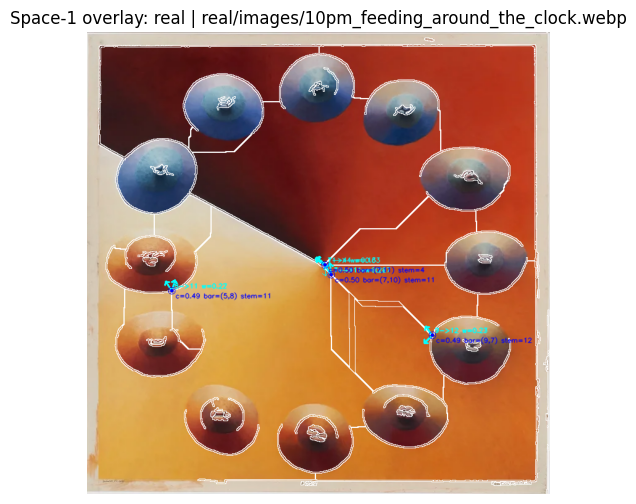

In [26]:
df_junc = pd.read_csv(SPACE_DIR / "junctions.csv")
df_edges = pd.read_csv(SPACE_DIR / "ownership_edges.csv")

# Pick one row from manifest to preview
row0 = df_manifest.iloc[0]
split0 = row0["split"]
image_id0 = row0["image_id"]
path0 = DATA_DIR / image_id0

rgb = imread_rgb(path0)
gray = to_gray(rgb)

edges = edge_map_multiscale(gray)
sal01  = saliency_map(gray)
labels = region_map_from_edges(gray, edges)

H, W = gray.shape
min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
labels = filter_small_regions(labels, min_area_px=min_area_px)

ann = annotate_space1_image(split0, image_id0, rgb, gray, labels, df_junc, df_edges,
                            show_boundaries=True, arrow_scale=18, min_conf=0.0)

plt.figure(figsize=(10,6))
plt.imshow(ann)
plt.axis("off")
plt.title(f"Space-1 overlay: {split0} | {image_id0}")
plt.show()

### Batch Export

In [28]:
import os

# rank images by max junction confidence
if len(df_junc) > 0:
    top = (df_junc.groupby(["split","image_id"])["confidence"]
                 .max()
                 .reset_index()
                 .sort_values("confidence", ascending=False)
                 .head(20))
else:
    top = pd.DataFrame(columns=["split","image_id","confidence"])

print("Top examples:")
display(top)

for _, r in top.iterrows():
    split = r["split"]; image_id = r["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path)
    gray = to_gray(rgb)

    edges = edge_map_multiscale(gray)
    labels = region_map_from_edges(gray, edges)

    H, W = gray.shape
    min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
    labels = filter_small_regions(labels, min_area_px=min_area_px)

    ann = annotate_space1_image(split, image_id, rgb, gray, labels, df_junc, df_edges,
                                show_boundaries=True, arrow_scale=18, min_conf=0.0)

    # safe filename
    base = os.path.basename(str(image_id)).replace("/", "_").replace("\\", "_")
    out_path = DEBUG_DIR / f"space1_{split}_{base}.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(ann, cv2.COLOR_RGB2BGR))

print("Saved Space-1 overlays to:", DEBUG_DIR)

Top examples:


,split,image_id,confidence
64,real,real/images/Meeting_Place.webp,0.751825
69,real,real/images/Nipple_Talk.webp,0.682507
53,real,real/images/Finding_Time.webp,0.672350
6,generated,generated/ComfyUI_00102_.png,0.662476
31,generated,generated/ComfyUI_00156_.png,0.633836
38,real,real/images/Belly_breast.webp,0.627908
56,real,real/images/Fully_Dilated.webp,0.625975
21,generated,generated/ComfyUI_00138_.png,0.624049
79,real,real/images/Pressure_blue_purple.webp,0.618444
26,generated,generated/ComfyUI_00146_.png,0.613509


Saved Space-1 overlays to: outputs\space\debug


### Amodal Completion & Good Continuation

In [15]:
from skimage.morphology import skeletonize

SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

# occlusion strength (fill missing with 0)
df_occ = pd.read_csv(SPACE_DIR / "ownership_edges_v2.csv")
occ_strength = df_occ.groupby(["split","image_id"])["weight"].sum().to_dict()

In [16]:
MAX_LINK_DIST = 90       # px (increased)
MIN_EP_SEP    = 6        # px (avoid pairing same spot)
KNN           = 8        # candidates per endpoint
NEAR_R        = 10       # local radius for tangent estimation (skeleton PCA)
LOCAL_WIN     = 80       # window for complexity check

# score weights
W_DIST = 1.0
W_FACE = 1.8
W_ORI  = 1.6

# plausibility weights
ALPHA_COMPLEX = 1.0
BETA_CURV     = 0.3

# thresholds
MIN_ASSOC_SCORE = 0.02   # relaxed

In [17]:
def unit(v, eps=1e-9):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    return v / (n + eps)

def angle_between(u, v):
    u = unit(u); v = unit(v)
    dot = float(np.clip(np.dot(u, v), -1.0, 1.0))
    return float(math.acos(dot))

def exp_score(x, scale):
    return float(math.exp(-(x/scale)**2))

def neighbor_count(sk, y, x):
    patch = sk[y-1:y+2, x-1:x+2]
    return int(patch.sum() - sk[y,x])

def skeleton_endpoints_and_tangents(sk, near_r=NEAR_R):
    """
    sk: binary skeleton (bool)
    Returns list of endpoints with (x,y,tangent_vec)
    tangent via PCA of local skeleton pixels around endpoint.
    """
    H, W = sk.shape
    ys, xs = np.where(sk)
    sk_u8 = sk.astype(np.uint8)

    # find endpoints
    eps = []
    for y, x in zip(ys, xs):
        if y == 0 or x == 0 or y == H-1 or x == W-1:
            continue
        deg = neighbor_count(sk_u8, y, x)
        if deg == 1:
            eps.append((x, y))

    # tangent estimation
    out = []
    for (x0, y0) in eps:
        y1 = max(0, y0-near_r); y2 = min(H, y0+near_r+1)
        x1 = max(0, x0-near_r); x2 = min(W, x0+near_r+1)
        patch = sk[y1:y2, x1:x2]
        py, px = np.where(patch)
        if len(px) < 6:
            # fallback: point outward (arbitrary)
            t = np.array([1.0, 0.0], dtype=float)
            out.append({"x": x0, "y": y0, "t": t})
            continue

        # coords in absolute
        pts = np.stack([px + x1, py + y1], axis=1).astype(np.float32)  # (x,y)
        mu = pts.mean(axis=0, keepdims=True)
        X = pts - mu
        C = (X.T @ X) / max(len(pts)-1, 1)
        w, v = np.linalg.eigh(C)
        idx = np.argsort(w)[::-1]
        v = v[:, idx]
        t = v[:, 0].astype(float)  # principal direction in (x,y)

        # orient tangent to point away from local mass center
        # (so facing constraint becomes meaningful)
        outward = np.array([x0, y0], dtype=float) - mu[0]
        if np.dot(t, outward) < 0:
            t = -t
        out.append({"x": x0, "y": y0, "t": unit(t)})

    return out

def local_skeleton_complexity(edge_mask, center_xy, win=LOCAL_WIN):
    H, W = edge_mask.shape
    cx, cy = int(center_xy[0]), int(center_xy[1])
    r0 = max(0, cy - win); r1 = min(H, cy + win + 1)
    c0 = max(0, cx - win); c1 = min(W, cx + win + 1)
    patch = edge_mask[r0:r1, c0:c1].astype(bool)
    if patch.sum() < 10:
        return 0.0

    sk = skeletonize(patch).astype(np.uint8)

    bp = 0
    for y in range(1, sk.shape[0]-1):
        for x in range(1, sk.shape[1]-1):
            if sk[y,x] == 0:
                continue
            nb = int(np.sum(sk[y-1:y+2, x-1:x+2]) - 1)
            if nb >= 3:
                bp += 1

    length = int(sk.sum())
    return float(bp + 0.01*length)

def draw_line_mask(H, W, p, q):
    m = np.zeros((H, W), dtype=np.uint8)
    cv2.line(m, tuple(np.round(p).astype(int)), tuple(np.round(q).astype(int)), 255, 1, cv2.LINE_AA)
    return (m > 0)

def draw_bezier_mask(H, W, p, q, tp, tq):
    m = np.zeros((H, W), dtype=np.uint8)
    p = np.array(p, float); q = np.array(q, float)
    mid = 0.5*(p+q)
    d = np.linalg.norm(q-p) + 1e-9
    v = unit(tp + (-tq))
    ctrl = mid + 0.25*d*v

    pts = []
    for t in np.linspace(0, 1, 60):
        pt = (1-t)**2*p + 2*(1-t)*t*ctrl + t**2*q
        pts.append(pt)
    pts = np.array(pts)
    pts_i = np.round(pts).astype(int)
    pts_i[:,0] = np.clip(pts_i[:,0], 0, W-1)
    pts_i[:,1] = np.clip(pts_i[:,1], 0, H-1)

    for i in range(len(pts_i)-1):
        cv2.line(m, tuple(pts_i[i]), tuple(pts_i[i+1]), 255, 1, cv2.LINE_AA)

    # curvature penalty proxy
    vseg = np.diff(pts, axis=0)
    vseg = np.array([unit(x) for x in vseg])
    angs = [angle_between(vseg[i], vseg[i+1]) for i in range(len(vseg)-1)]
    curv = float(np.mean(angs)) if len(angs) else 0.0
    return (m > 0), curv

link_rows = []
idx_rows = []

for _, row in df_manifest.iterrows():
    split = row["split"]
    image_id = row["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path)
    gray = to_gray(rgb)
    H, W = gray.shape

    E = edge_map_multiscale(gray)           # 0/1
    sk = skeletonize(E > 0)                 # bool skeleton

    endpoints = skeleton_endpoints_and_tangents(sk, near_r=NEAR_R)
    n_ep = len(endpoints)

    if n_ep < 4:
        occ = float(occ_strength.get((split, image_id), 0.0))
        idx_rows.append({
            "split": split, "image_id": image_id,
            "space2_n_endpoints": int(n_ep),
            "space2_n_links": 0,
            "space2_completion_signal": 0.0,
            "space2_completion_simplicity": 0.0,
            "space2_occlusion_strength": float(occ),
            "space2_completion_tension": 0.0
        })
        continue

    # build candidate links
    KNN = 30                 # more neighbors
    MIN_ASSOC_SCORE = 0.001  # much more permissive
    MAX_LINK_DIST = 140      # allow farther completion

    def undirected_align_angle(t, v):
        # best alignment of line direction (t or -t) with v
        return min(angle_between(t, v), angle_between(-t, v))

    cand = []
    pts = np.array([[e["x"], e["y"]] for e in endpoints], dtype=float)

    for i in range(n_ep):
        pi = pts[i]
        dists = np.linalg.norm(pts - pi, axis=1)
        nn_idx = np.argsort(dists)[1:KNN+1]  # skip self

        ti = endpoints[i]["t"]

        for j in nn_idx:
            pj = pts[j]
            d = float(dists[j])
            if d < MIN_EP_SEP or d > MAX_LINK_DIST:
                continue

            tj = endpoints[j]["t"]
            v_ij = unit(pj - pi)

            # undirected alignment with the connection direction
            a_i = undirected_align_angle(ti, v_ij)      # 0 is best
            a_j = undirected_align_angle(tj, -v_ij)     # 0 is best

            # undirected tangent agreement (line-like continuation)
            ori = min(angle_between(ti, tj), angle_between(ti, -tj))  # 0 is best

            # scoring (relaxed scales!)
            s_dist  = exp_score(d, scale=MAX_LINK_DIST/1.8)
            s_align = exp_score(a_i + a_j, scale=1.8)   # forgiving
            s_ori   = exp_score(ori, scale=1.4)

            score = (s_dist**1.0) * (s_align**1.2) * (s_ori**1.0)

            if score >= MIN_ASSOC_SCORE:
                cand.append((score, i, j, d, ori, a_i, a_j))

    # dedupe symmetric pairs
    uniq = {}
    for item in cand:
        score, i, j, *_ = item
        a, b = (i, j) if i < j else (j, i)
        if (a,b) not in uniq or score > uniq[(a,b)][0]:
            uniq[(a,b)] = item

    cand = list(uniq.values())
    cand.sort(key=lambda x: x[0], reverse=True)

    # greedy non-conflicting matching
    used = set()
    chosen = []
    for score, i, j, d, ori, a_i, a_j in cand:
        if i in used or j in used:
            continue
        used.add(i); used.add(j)
        chosen.append((score, i, j, d, ori, a_i, a_j))

    completion_signal = 0.0
    simplicity_accum = 0.0

    for k, (score, i, j, d, ori, face_i, face_j) in enumerate(chosen):
        pi = pts[i]; pj = pts[j]
        ti = endpoints[i]["t"]; tj = endpoints[j]["t"]
        center = 0.5*(pi + pj)

        comp_before = local_skeleton_complexity(E > 0, center_xy=center, win=LOCAL_WIN)

        m_line = draw_line_mask(H, W, pi, pj)
        comp_line = local_skeleton_complexity((E > 0) | m_line, center_xy=center, win=LOCAL_WIN)
        obj_line = ALPHA_COMPLEX * (comp_line - comp_before)

        m_bez, curv = draw_bezier_mask(H, W, pi, pj, ti, tj)
        comp_bez = local_skeleton_complexity((E > 0) | m_bez, center_xy=center, win=LOCAL_WIN)
        obj_bez = ALPHA_COMPLEX * (comp_bez - comp_before) + BETA_CURV * curv

        if obj_bez < obj_line:
            mode = "bezier"; obj = obj_bez; comp_after = comp_bez
        else:
            mode = "line"; obj = obj_line; comp_after = comp_line

        plaus = float(score * math.exp(-max(obj, 0.0)))

        completion_signal += plaus
        simplicity_accum += float(math.exp(-max(obj, 0.0)))

        link_rows.append({
            "split": split, "image_id": image_id,
            "link_id": k,
            "score_assoc": float(score),
            "plausibility": float(plaus),
            "mode": mode,
            "dist_px": float(d),
            "ori_rad": float(ori),
            "face_i_rad": float(face_i),
            "face_j_rad": float(face_j),
            "comp_before": float(comp_before),
            "comp_after": float(comp_after),
            "obj": float(obj),
            "p1_x": float(pi[0]), "p1_y": float(pi[1]),
            "p2_x": float(pj[0]), "p2_y": float(pj[1]),
        })

    occ = float(occ_strength.get((split, image_id), 0.0))
    tension = float(completion_signal * occ)
    simp = float(simplicity_accum / max(len(chosen), 1)) if len(chosen) else 0.0

    idx_rows.append({
        "split": split, "image_id": image_id,
        "space2_n_endpoints": int(n_ep),
        "space2_n_links": int(len(chosen)),
        "space2_completion_signal": float(completion_signal),
        "space2_completion_simplicity": float(simp),
        "space2_occlusion_strength": float(occ),
        "space2_completion_tension": float(tension),
    })

df_links = pd.DataFrame(link_rows)
df_idx = pd.DataFrame(idx_rows)

eps = 1e-9
df_idx["space2_completion_per_endpoint"] = (
    df_idx["space2_completion_signal"] / (df_idx["space2_n_endpoints"] + eps)
)
df_idx["space2_completion_per_link"] = (
    df_idx["space2_completion_signal"] / (df_idx["space2_n_links"] + eps)
)

df_links.to_csv(SPACE_DIR / "space2_links_v2.csv", index=False)
df_idx.to_csv(SPACE_DIR / "space2_indices_v2.csv", index=False)


print("Saved:", SPACE_DIR / "space2_links_v2.csv", SPACE_DIR / "space2_indices_v2.csv")
print("links_v2:", df_links.shape, "indices_v2:", df_idx.shape)
display(df_idx.head())

Saved: outputs\space\space2_links_v2.csv outputs\space\space2_indices_v2.csv
links_v2: (5641, 17) indices_v2: (130, 10)


,split,image_id,space2_n_endpoints,space2_n_links,space2_completion_signal,space2_completion_simplicity,space2_occlusion_strength,space2_completion_tension,space2_completion_per_endpoint,space2_completion_per_link
0,real,real/images/10pm_feeding_around_the_clock.webp,144,69,9.145635,0.261305,0.001634,0.014944,0.063511,0.132545
1,real,real/images/11pm.webp,5,2,0.005055,0.004536,0.000000,0.000000,0.001011,0.002527
2,real,real/images/12_4_7_10.webp,233,112,11.363881,0.138887,0.000222,0.002524,0.048772,0.101463
3,real,real/images/around_the_clock.webp,25,10,1.432826,0.294830,0.006910,0.009901,0.057313,0.143283
4,real,real/images/around_the_clock_alizarin.webp,20,7,2.002585,0.349383,0.000000,0.000000,0.100129,0.286084


In [29]:
SPACE2_DEBUG_DIR = SPACE_DIR / "debug_space2"
SPACE2_DEBUG_DIR.mkdir(parents=True, exist_ok=True)

df_s2_links = pd.read_csv(SPACE_DIR / "space2_links_v2.csv")
df_s2_idx   = pd.read_csv(SPACE_DIR / "space2_indices_v2.csv")

def neighbor_count_u8(sk_u8, y, x):
    patch = sk_u8[y-1:y+2, x-1:x+2]
    return int(patch.sum() - sk_u8[y, x])

def skeleton_endpoints(sk_bool):
    """
    Returns list of endpoints as (x,y) in image coords.
    """
    H, W = sk_bool.shape
    sk_u8 = sk_bool.astype(np.uint8)
    ys, xs = np.where(sk_bool)
    eps = []
    for y, x in zip(ys, xs):
        if y <= 0 or x <= 0 or y >= H-1 or x >= W-1:
            continue
        if neighbor_count_u8(sk_u8, y, x) == 1:
            eps.append((int(x), int(y)))
    return eps

def draw_polyline(out_u8, pts_xy, thickness=1):
    pts = np.array(pts_xy, dtype=np.int32).reshape(-1, 1, 2)
    cv2.polylines(out_u8, [pts], isClosed=False, color=(0,255,0), thickness=thickness, lineType=cv2.LINE_AA)

def bezier_points(p, q, ctrl, n=60):
    pts = []
    for t in np.linspace(0, 1, n):
        pt = (1-t)**2*p + 2*(1-t)*t*ctrl + t**2*q
        pts.append(pt)
    pts = np.array(pts)
    return pts

def annotate_space2_image(split, image_id, rgb, gray,
                          df_links,
                          show_skeleton=True,
                          show_endpoints=True,
                          show_link_labels=True,
                          min_plaus=0.0):
    """
    Overlay:
    - skeleton (optional)
    - endpoints (dots)
    - chosen completion links from space2_links_v2.csv (line/bezier)
    """
    # ensure uint8 RGB
    if rgb.dtype != np.uint8:
        rgb_u8 = (np.clip(rgb, 0, 1) * 255).astype(np.uint8) if rgb.max() <= 1.5 else rgb.astype(np.uint8)
    else:
        rgb_u8 = rgb.copy()

    out = rgb_u8.copy()

    # recompute skeleton for visuals (same basis as Space-2)
    E = edge_map_multiscale(gray)
    sk = skeletonize((E > 0)).astype(bool)

    if show_skeleton:
        # draw skeleton in white
        out[sk] = (255, 255, 255)

    if show_endpoints:
        eps = skeleton_endpoints(sk)
        for (x, y) in eps:
            cv2.circle(out, (x, y), 2, (0, 0, 255), -1)  # red endpoints

    # filter chosen links for this image
    L = df_links[(df_links["split"] == split) & (df_links["image_id"] == image_id)].copy()
    if L.empty:
        return out

    H, W = gray.shape

    # draw links
    for _, r in L.iterrows():
        plaus = float(r.get("plausibility", 0.0))
        if plaus < min_plaus:
            continue

        mode = str(r.get("mode", "line"))
        p1 = np.array([float(r["p1_x"]), float(r["p1_y"])], dtype=float)
        p2 = np.array([float(r["p2_x"]), float(r["p2_y"])], dtype=float)

        # thickness: plausibility-scaled
        thick = int(np.clip(1 + 6*plaus, 1, 7))

        if mode == "bezier":
            # recreate the curve using stored endpoints only (no tangents saved),
            # so we use a mild control point at the midpoint (simple, stable).
            mid = 0.5*(p1+p2)
            v = p2 - p1
            # perpendicular nudge (deterministic)
            perp = np.array([-v[1], v[0]], dtype=float)
            n = np.linalg.norm(perp) + 1e-9
            perp = perp / n
            ctrl = mid + 0.15*np.linalg.norm(v)*perp

            pts = bezier_points(p1, p2, ctrl, n=50)
            pts[:,0] = np.clip(pts[:,0], 0, W-1)
            pts[:,1] = np.clip(pts[:,1], 0, H-1)
            draw_polyline(out, pts, thickness=thick)
        else:
            cv2.line(out,
                     tuple(np.round(p1).astype(int)),
                     tuple(np.round(p2).astype(int)),
                     color=(0,255,0),
                     thickness=thick,
                     lineType=cv2.LINE_AA)

        if show_link_labels:
            cx, cy = int(round(0.5*(p1[0]+p2[0]))), int(round(0.5*(p1[1]+p2[1])))
            txt = f"{mode} p={plaus:.2f}"
            cv2.putText(out, txt, (cx+4, cy+4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,255,0), 1, cv2.LINE_AA)

    return out

### Single Image

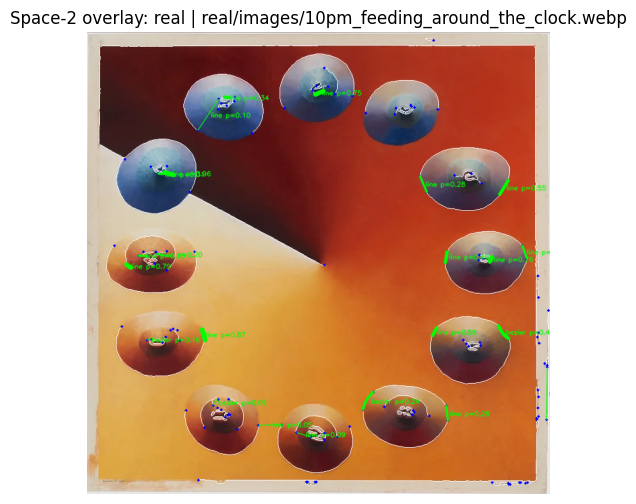

In [31]:
# pick one image to preview (try your earlier example)
split0 = "real"
image_id0 = "real/images/10pm_feeding_around_the_clock.webp"

path0 = DATA_DIR / image_id0
rgb = imread_rgb(path0)
gray = to_gray(rgb)

ann2 = annotate_space2_image(split0, image_id0, rgb, gray, df_s2_links,
                             show_skeleton=True, show_endpoints=True,
                             show_link_labels=True, min_plaus=0.05)

plt.figure(figsize=(10,6))
plt.imshow(ann2)
plt.axis("off")
plt.title(f"Space-2 overlay: {split0} | {image_id0}")
plt.show()

In [32]:
top2 = (df_s2_idx.sort_values("space2_completion_signal", ascending=False)
               .head(20)[["split","image_id","space2_completion_signal","space2_n_links"]])

print("Top Space-2 completion examples:")
display(top2)

for _, r in top2.iterrows():
    split = r["split"]; image_id = r["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path)
    gray = to_gray(rgb)

    ann2 = annotate_space2_image(split, image_id, rgb, gray, df_s2_links,
                                 show_skeleton=True, show_endpoints=True,
                                 show_link_labels=False, min_plaus=0.05)

    base = os.path.basename(str(image_id)).replace("/", "_").replace("\\", "_")
    out_path = SPACE2_DEBUG_DIR / f"space2_{split}_{base}.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(ann2, cv2.COLOR_RGB2BGR))

print("Saved Space-2 overlays to:", SPACE2_DEBUG_DIR)

Top Space-2 completion examples:


,split,image_id,space2_completion_signal,space2_n_links
38,real,real/images/Linked_Lingam_Orange.webp,177.716419,923
30,real,real/images/Full_Bodied.webp,86.219365,560
5,real,real/images/Belly_breast.webp,53.823702,328
8,real,real/images/Birth_perspective_from_above_and_b...,26.673192,365
41,real,real/images/Meeting_in_the_middle.webp,25.780752,147
28,real,real/images/Fourteen_Saints.webp,24.354239,383
19,real,real/images/Descent_into_chaos.webp,18.490848,140
49,real,real/images/Nipple_Talk.webp,18.010660,122
6,real,real/images/Belly_breast_face_brain_placenta.webp,16.593868,252
44,real,real/images/Milk_Fountain.webp,14.578836,133


Saved Space-2 overlays to: outputs\space\debug_space2


### Transparency Detection

In [40]:
SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load region features from Shape step (adjust path if yours differs) ----
# REGION_FEATS_PATH = r"F:\New Dissertation - Image Generation\POC\outputs\shape_region_features.csv"
# df_reg = pd.read_csv(REGION_FEATS_PATH)

# Column names (adjust if needed)
REGION_ID_COL = "region_index"   # or "region_id" depending on your file
AREA_RATIO_COL = "area_ratio"    # must exist

In [41]:
MIN_OVERLAP_AREA_RATIO = 0.003     # ignore tiny overlap patches
MAX_OVERLAP_AREA_RATIO = 0.15     # ignore huge regions (unlikely overlap)
MIN_PARENT_AREA_RATIO  = 0.01      # parents should be meaningful
TOPK_PARENTS = 2                   # overlap region explained by two parents
MIN_BOUNDARY_SUPPORT = 0.08        # each parent must account for >=18% of overlap boundary
TAU_PHOTO = 0.18                   # tolerance for mixture residual (in [0,1] rgb)
MIN_ALPHA_MARGIN = 0.05            # avoid degenerate alpha ~0 or ~1 (optional)
CONF_THRESH = 0.25                 # “transparency present” threshold


### Helper Functions (Adjacency, Boundary Support between labels)

In [42]:
from collections import defaultdict


def boundary_contacts(L):
    """
    Returns:
      adj[(a,b)] = boundary contact count between regions a and b (unordered a<b)
      boundary_len[a] = total boundary contact counts for region a (approx)
    """
    H, W = L.shape
    adj = defaultdict(int)
    boundary_len = defaultdict(int)

    # horizontal neighbors
    a = L[:, :-1]
    b = L[:, 1:]
    mask = (a != b)
    aa = a[mask].ravel()
    bb = b[mask].ravel()
    for x, y in zip(aa, bb):
        i, j = (int(x), int(y))
        if i == 0 or j == 0:  # if you use 0 as background, keep or remove as you like
            pass
        p, q = (i, j) if i < j else (j, i)
        adj[(p, q)] += 1
        boundary_len[i] += 1
        boundary_len[j] += 1

    # vertical neighbors
    a = L[:-1, :]
    b = L[1:, :]
    mask = (a != b)
    aa = a[mask].ravel()
    bb = b[mask].ravel()
    for x, y in zip(aa, bb):
        i, j = (int(x), int(y))
        p, q = (i, j) if i < j else (j, i)
        adj[(p, q)] += 1
        boundary_len[i] += 1
        boundary_len[j] += 1

    return adj, boundary_len

def mean_rgb(img_rgb, mask_bool):
    if mask_bool.sum() == 0:
        return np.array([np.nan, np.nan, np.nan], dtype=float)
    pix = img_rgb[mask_bool]
    return np.nanmean(pix.reshape(-1, 3), axis=0)

def best_alpha_and_residual(A, B, C):
    """
    A,B,C: RGB in [0,1]
    Find alpha minimizing || C - (alpha*A + (1-alpha)*B) ||_2
    """
    A = np.asarray(A, float); B = np.asarray(B, float); C = np.asarray(C, float)
    AB = A - B
    denom = float(np.dot(AB, AB) + 1e-9)
    alpha = float(np.dot(C - B, AB) / denom)
    alpha = float(np.clip(alpha, 0.0, 1.0))
    pred = alpha*A + (1.0-alpha)*B
    resid = float(np.linalg.norm(C - pred))
    sep = float(np.linalg.norm(A - B) + 1e-9)
    resid_norm = resid / sep  # normalized by contrast between parents
    return alpha, resid_norm

def photo_consistency(resid_norm, tau=TAU_PHOTO):
    # higher is better; resid_norm ~0 means perfect mixture
    return float(math.exp(- (resid_norm / tau)**2))

def shape_superposition_score(reg_row):
    """
    Geometric plausibility proxy using Shape metrics you already compute.
    Keep it simple + interpretable:
      - prefer symmetric/smooth (overlap patches often have coherent contour)
      - penalize highly anisotropic noise
    """
    sym = float(reg_row.get("symmetry_pca", 0.0))
    smooth = float(reg_row.get("smoothness", 0.0))
    eig = float(reg_row.get("pca_eig_ratio", 1.0))  # higher => more elongated; overlap patches often moderate
    # Convert to [0,1] soft score
    s = 0.55*sym + 0.45*smooth
    # penalty if extremely elongated
    elong_pen = float(math.exp(-max(eig - 6.0, 0.0) / 3.0))
    return float(np.clip(s, 0.0, 1.0) * elong_pen)

In [43]:
cand_rows = []
idx_rows  = []

for _, m in df_manifest.iterrows():
    split = m["split"]
    image_id = m["image_id"]
    path = DATA_DIR / image_id

    rgb = imread_rgb(path).astype(np.float32)
    if rgb.max() > 1.5:
        rgb = rgb / 255.0

    gray = to_gray(rgb)
    gray_u8 = (np.clip(gray, 0, 1) * 255).astype(np.uint8)

    E = edge_map_multiscale(gray_u8)
    edge_bin = (E > 0).astype(np.uint8)
    L = region_map_from_edges(E, edge_bin)

    adj, blen = boundary_contacts(L)

    region_ids, counts = np.unique(L, return_counts=True)
    H, W = L.shape
    area_ratio = {int(r): float(c)/(H*W) for r, c in zip(region_ids, counts)}

    per_region_neighbors = defaultdict(list)
    for (a, b), c in adj.items():
        per_region_neighbors[a].append((b, c))
        per_region_neighbors[b].append((a, c))

    image_candidates = []

    for r in region_ids:
        r = int(r)

        # (optional) skip background if you have one
        # if r == 0: continue

        ar = area_ratio.get(r, 0.0)
        if ar < MIN_OVERLAP_AREA_RATIO or ar > MAX_OVERLAP_AREA_RATIO:
            continue

        nbrs = sorted(per_region_neighbors.get(r, []), key=lambda x: x[1], reverse=True)
        if len(nbrs) < 2:
            continue

        (p1, c1), (p2, c2) = nbrs[0], nbrs[1]
        p1 = int(p1); p2 = int(p2)

        if area_ratio.get(p1, 0.0) < MIN_PARENT_AREA_RATIO or area_ratio.get(p2, 0.0) < MIN_PARENT_AREA_RATIO:
            continue

        total_boundary = float(blen.get(r, 1))
        sup1 = float(c1) / total_boundary
        sup2 = float(c2) / total_boundary
        if sup1 < MIN_BOUNDARY_SUPPORT or sup2 < MIN_BOUNDARY_SUPPORT:
            continue

        mask_r  = (L == r)
        mask_p1 = (L == p1)
        mask_p2 = (L == p2)

        C = mean_rgb(rgb, mask_r)
        A = mean_rgb(rgb, mask_p1)
        B = mean_rgb(rgb, mask_p2)

        if not np.isfinite(C).all() or not np.isfinite(A).all() or not np.isfinite(B).all():
            continue

        alpha, resid_norm = best_alpha_and_residual(A, B, C)
        photo = photo_consistency(resid_norm, tau=TAU_PHOTO)
        geo   = geo_overlap_simplicity(mask_r)
        support = float(min(sup1, sup2))

        conf = float(geo * photo * support)

        cand_rows.append({
            "split": split, "image_id": image_id,
            "overlap_region": r,
            "parent_1": p1, "parent_2": p2,
            "overlap_area_ratio": ar,
            "boundary_support_p1": sup1,
            "boundary_support_p2": sup2,
            "geo_superposition": geo,
            "photo_resid_norm": resid_norm,
            "alpha": alpha,
            "photo_consistency": photo,
            "transparency_confidence": conf
        })
        image_candidates.append(conf)

    if len(image_candidates) == 0:
        idx_rows.append({
            "split": split, "image_id": image_id,
            "space3_n_candidates": 0,
            "space3_transparency_score": 0.0,
            "space3_transparency_mean": 0.0,
            "space3_transparency_present": 0
        })
    else:
        mx = float(np.max(image_candidates))
        mn = float(np.mean(image_candidates))
        idx_rows.append({
            "split": split, "image_id": image_id,
            "space3_n_candidates": int(len(image_candidates)),
            "space3_transparency_score": mx,
            "space3_transparency_mean": mn,
            "space3_transparency_present": int(mx >= CONF_THRESH)
        })

df_cand = pd.DataFrame(cand_rows)
df_idx  = pd.DataFrame(idx_rows)

df_cand.to_csv(SPACE_DIR / "space3_candidates.csv", index=False)
df_idx.to_csv(SPACE_DIR / "space3_indices.csv", index=False)

print("Saved:", SPACE_DIR / "space3_candidates.csv", SPACE_DIR / "space3_indices.csv")
print("candidates:", df_cand.shape, "indices:", df_idx.shape)
display(df_idx.head())

Saved: outputs\space\space3_candidates.csv outputs\space\space3_indices.csv
candidates: (906, 13) indices: (130, 6)


,split,image_id,space3_n_candidates,space3_transparency_score,space3_transparency_mean,space3_transparency_present
0,real,real/images/10pm_feeding_around_the_clock.webp,7,0.216566,0.051971,0
1,real,real/images/11pm.webp,5,0.329015,0.221483,1
2,real,real/images/12_4_7_10.webp,9,0.225923,0.134077,0
3,real,real/images/around_the_clock.webp,17,0.252780,0.110463,1
4,real,real/images/around_the_clock_alizarin.webp,3,0.103321,0.073726,0


### Visual Verification

#### Helper Functions

In [44]:
def mask_outline(mask_bool, thickness=2):
    """Return outline mask of a boolean region mask."""
    m = (mask_bool.astype(np.uint8) * 255)
    # morphological gradient = outline
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    dil = cv2.dilate(m, k, iterations=thickness)
    ero = cv2.erode(m, k, iterations=thickness)
    out = (dil > 0) & ~(ero > 0)
    return out

def overlay_fill_on_rgb(rgb01, mask_bool, color_rgb=(1.0, 0.0, 0.0), alpha=0.35):
    """Overlay a FILLED boolean mask onto rgb [0,1] with alpha blending."""
    out = rgb01.copy()
    if mask_bool is None or mask_bool.sum() == 0:
        return out
    m = mask_bool.astype(bool)
    out[m, 0] = (1 - alpha) * out[m, 0] + alpha * color_rgb[0]
    out[m, 1] = (1 - alpha) * out[m, 1] + alpha * color_rgb[1]
    out[m, 2] = (1 - alpha) * out[m, 2] + alpha * color_rgb[2]
    return out

def overlay_mask_on_rgb(rgb01, outline_mask, color_rgb=(1.0, 0.0, 0.0), alpha=0.9):
    """Draw colored outline onto rgb [0,1]."""
    out = rgb01.copy()
    if outline_mask is None or outline_mask.sum() == 0:
        return out
    yx = np.where(outline_mask)
    out[yx[0], yx[1], 0] = (1-alpha)*out[yx[0], yx[1], 0] + alpha*color_rgb[0]
    out[yx[0], yx[1], 1] = (1-alpha)*out[yx[0], yx[1], 1] + alpha*color_rgb[1]
    out[yx[0], yx[1], 2] = (1-alpha)*out[yx[0], yx[1], 2] + alpha*color_rgb[2]
    return out

def ensure_rgb01(rgb):
    rgb = rgb.astype(np.float32)
    if rgb.max() > 1.5:
        rgb = rgb / 255.0
    return np.clip(rgb, 0, 1)

def annotate_transparency_for_image(
    split, image_id, df_cand,
    topk=5,
    conf_min=0.15,
    save_dir=None,
    show=True,
    figsize=(7,7),
    title_prefix="Space-3 overlay"
):
    """
    Makes an overlay figure for a single image showing top-k transparency candidates.
    """

    # --- load image
    path = DATA_DIR / image_id
    rgb = ensure_rgb01(imread_rgb(path))
    gray = to_gray(rgb)

    # --- rebuild labels (MUST match your pipeline)
    edges = edge_map_multiscale(gray)  # whatever you already use
    # IMPORTANT: use same signature you used in Space-1
    labels = region_map_from_edges(gray, edges)

    # --- candidates for this image
    dfI = df_cand[(df_cand["split"] == split) & (df_cand["image_id"] == image_id)].copy()
    if dfI.empty:
        print("No candidates for:", split, image_id)
        return None

    dfI = dfI.sort_values("transparency_confidence", ascending=False)
    dfI = dfI[dfI["transparency_confidence"] >= conf_min].head(topk)

    if dfI.empty:
        print("Candidates exist, but none pass conf_min for:", split, image_id)
        return None

    base = rgb.copy()

    # Colors: parents and overlap
    COL_P1 = (0.0, 0.9, 1.0)   # cyan
    COL_P2 = (1.0, 0.6, 0.0)   # orange
    COL_OV = (1.0, 0.0, 1.0)   # magenta

    # For stacking text labels nicely
    text_lines = []

    # Draw top-k candidates (each candidate can re-use parents; outlines accumulate)
    for k, (_, r) in enumerate(dfI.iterrows()):
        ov = int(r["overlap_region"])
        p1 = int(r["parent_1"])
        p2 = int(r["parent_2"])
        conf = float(r["transparency_confidence"])

        alpha = float(r.get("alpha", np.nan))
        photo = float(r.get("photo_consistency", np.nan))
        geo = float(r.get("geo_superposition", np.nan))

        ov_outline = mask_outline(labels == ov, thickness=2)
        p1_outline = mask_outline(labels == p1, thickness=2)
        p2_outline = mask_outline(labels == p2, thickness=2)

        ov_mask = (labels == ov)
        p1_mask = (labels == p1)
        p2_mask = (labels == p2)

        base = overlay_mask_on_rgb(base, p1_outline, COL_P1, alpha=0.85)
        base = overlay_mask_on_rgb(base, p2_outline, COL_P2, alpha=0.85)
        base = overlay_mask_on_rgb(base, ov_outline, COL_OV, alpha=0.95)

        # fill
        base = overlay_fill_on_rgb(base, p1_mask, COL_P1, alpha=0.18)
        base = overlay_fill_on_rgb(base, p2_mask, COL_P2, alpha=0.18)
        base = overlay_fill_on_rgb(base, ov_mask, COL_OV, alpha=0.35)

        # outline
        base = overlay_mask_on_rgb(base, mask_outline(p1_mask, 2), COL_P1, alpha=0.85)
        base = overlay_mask_on_rgb(base, mask_outline(p2_mask, 2), COL_P2, alpha=0.85)
        base = overlay_mask_on_rgb(base, mask_outline(ov_mask, 2), COL_OV, alpha=0.95)


        # optional boundary supports if present
        sup1 = r.get("boundary_support_p1", np.nan)
        sup2 = r.get("boundary_support_p2", np.nan)
        resid = r.get("photo_resid_norm", np.nan)

        line = f"#{k} ov={ov} p1={p1} p2={p2} | conf={conf:.3f} alpha={alpha:.2f} photo={photo:.2f} geo={geo:.2f}"
        if np.isfinite(sup1) and np.isfinite(sup2):
            line += f" sup=({sup1:.2f},{sup2:.2f})"
        if np.isfinite(resid):
            line += f" resid={resid:.2f}"
        text_lines.append(line)

    # plot
    plt.figure(figsize=figsize)
    plt.imshow(base)
    plt.axis("off")
    plt.title(f"{title_prefix}: {split} | {image_id}")

    # draw text box
    y0 = 10
    for i, line in enumerate(text_lines[:topk]):
        plt.text(
            10, y0 + 16*i, line,
            fontsize=8,
            color="white",
            bbox=dict(facecolor="black", alpha=0.45, edgecolor="none", pad=2)
        )

    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        safe_name = image_id.replace("/", "_").replace("\\", "_")
        out_path = save_dir / f"space3_{split}_{safe_name}.png"
        plt.savefig(out_path, dpi=160, bbox_inches="tight")
        print("Saved:", out_path)

    if show:
        plt.show()
    else:
        plt.close()

    return dfI

In [45]:
SPACE3_DEBUG_DIR = SPACE_DIR / "debug_space3"
SPACE3_DEBUG_DIR.mkdir(parents=True, exist_ok=True)

# Pick the "most transparent" images overall (max score per image)
df_img_best = (
    df_cand.groupby(["split", "image_id"], as_index=False)["transparency_confidence"]
          .max()
          .sort_values("transparency_confidence", ascending=False)
)

TOP_IMAGES = 20
for _, row in df_img_best.head(TOP_IMAGES).iterrows():
    annotate_transparency_for_image(
        split=row["split"],
        image_id=row["image_id"],
        df_cand=df_cand,
        topk=5,
        conf_min=0.12,              # tune if too strict/loose
        save_dir=SPACE3_DEBUG_DIR,
        show=False
    )

print("Saved Space-3 overlays to:", SPACE3_DEBUG_DIR)

Saved: outputs\space\debug_space3\space3_real_real_images_Pressure_blue_purple.webp.png
Saved: outputs\space\debug_space3\space3_real_real_images_Heavy_Burden.webp.png
Saved: outputs\space\debug_space3\space3_generated_generated_ComfyUI_00110_.png.png
Saved: outputs\space\debug_space3\space3_generated_generated_ComfyUI_00127_.png.png
Saved: outputs\space\debug_space3\space3_generated_generated_ComfyUI_00151_.png.png
Saved: outputs\space\debug_space3\space3_real_real_images_Orange_Brain.webp.png
Saved: outputs\space\debug_space3\space3_real_real_images_Blue_0_with_red_halo.webp.png
Saved: outputs\space\debug_space3\space3_real_real_images_Blue_Nip.webp.png
Saved: outputs\space\debug_space3\space3_generated_generated_ComfyUI_00129_.png.png
Saved: outputs\space\debug_space3\space3_real_real_images_11pm.webp.png
Saved: outputs\space\debug_space3\space3_generated_generated_ComfyUI_00094_.png.png
Saved: outputs\space\debug_space3\space3_generated_generated_ComfyUI_00122_.png.png
Saved: outpu

Saved: outputs\space\debug_space3_single\space3_real_real_images_10pm_feeding_around_the_clock.webp.png


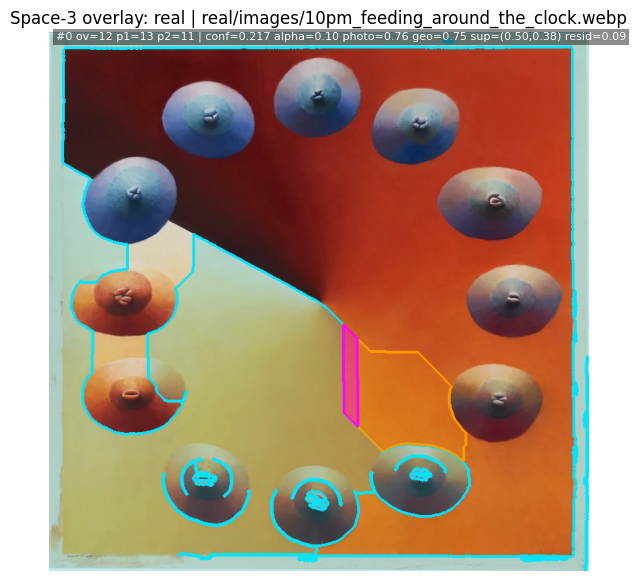

,split,image_id,overlap_region,parent_1,parent_2,overlap_area_ratio,boundary_support_p1,boundary_support_p2,geo_superposition,photo_resid_norm,alpha,photo_consistency,transparency_confidence
6,real,real/images/10pm_feeding_around_the_clock.webp,12,13,11,0.004174,0.5,0.381988,0.74712,0.094558,0.104195,0.75884,0.216566


In [46]:
annotate_transparency_for_image(
    split="real",
    image_id="real/images/10pm_feeding_around_the_clock.webp",
    df_cand=df_cand,
    topk=8,
    conf_min=0.10,
    save_dir=SPACE_DIR / "debug_space3_single",
    show=True
)

### Depth from Gradients (Gibsonian, but modern)

In [47]:
from scipy.stats import spearmanr

SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

# If you saved depth ranks from Space-1:
DEPTH_LEVELS_PATH = SPACE_DIR / "depth_levels.csv"  # or depth_levels_v2.csv if you used that
df_depth = None
if DEPTH_LEVELS_PATH.exists():
    df_depth = pd.read_csv(DEPTH_LEVELS_PATH)
    # expected cols: split,image_id,region_id,depth_rank

In [48]:
def ensure_rgb01(rgb):
    rgb = rgb.astype(np.float32)
    if rgb.max() > 1.5:
        rgb = rgb / 255.0
    return np.clip(rgb, 0, 1)

def safe_spearman(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    a = a[m]; b = b[m]
    if len(a) < 4:
        return np.nan
    r, _ = spearmanr(a, b)
    return float(r) if np.isfinite(r) else np.nan

def texture_energy_multiscale(gray_u8, sigmas=(1.0, 2.0, 4.0)):
    """
    Simple, robust texture-energy proxy:
    energy = mean over scales of gradient magnitude (Sobel) after Gaussian blur
    """
    gray = gray_u8.astype(np.float32)
    E = np.zeros_like(gray, dtype=np.float32)
    for s in sigmas:
        g = cv2.GaussianBlur(gray, (0,0), sigmaX=s, sigmaY=s)
        gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
        mag = cv2.magnitude(gx, gy)
        E += mag
    E /= float(len(sigmas))
    return E

def focus_laplacian(gray_u8):
    """
    Returns Laplacian response map (float). We'll aggregate per region.
    """
    g = gray_u8.astype(np.float32)
    lap = cv2.Laplacian(g, cv2.CV_32F, ksize=3)
    return lap

def nearest_neighbor_distances(centroids_xy):
    """
    centroids_xy: (N,2) in x,y
    Returns nn_dist for each point (N,)
    """
    pts = np.asarray(centroids_xy, float)
    n = len(pts)
    if n < 2:
        return np.full(n, np.nan, float)
    dmat = np.sqrt(((pts[None,:,:] - pts[:,None,:])**2).sum(axis=2))
    dmat[dmat == 0] = np.inf
    nn = np.min(dmat, axis=1)
    return nn

region_rows = []
image_rows  = []

for _, m in df_manifest.iterrows():
    split = m["split"]
    image_id = m["image_id"]
    path = DATA_DIR / image_id

    rgb = ensure_rgb01(imread_rgb(path))
    gray01 = to_gray(rgb)                      # your helper returns [0,1] float usually
    gray_u8 = (np.clip(gray01, 0, 1) * 255).astype(np.uint8)

    # rebuild labels EXACTLY like Space-1
    edges = edge_map_multiscale(gray_u8)       # you fixed Canny input earlier; keep u8
    labels = region_map_from_edges(gray_u8, edges)  # or region_map_from_edges(gray, edges) depending on your signature

    H, W = labels.shape
    min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
    labels = filter_small_regions(labels, min_area_px=min_area_px)

    region_ids = np.unique(labels)
    region_ids = region_ids[region_ids != 0]
    if len(region_ids) < 2:
        image_rows.append({
            "split": split, "image_id": image_id,
            "space4_n_regions": int(len(region_ids)),
            "space4_sizegrad_corr_depth": np.nan,
            "space4_sizegrad_corr_y": np.nan,
            "space4_spacinggrad_corr_depth": np.nan,
            "space4_spacinggrad_corr_y": np.nan,
            "space4_texgrad_corr_depth": np.nan,
            "space4_texgrad_corr_y": np.nan,
            "space4_sharpgrad_corr_depth": np.nan,
            "space4_sharpgrad_corr_y": np.nan,
            "space4_depthcue_strength": 0.0,
        })
        continue

    # depth ranks lookup (optional but ideal)
    depth_map = {}
    if df_depth is not None:
        dfi = df_depth[(df_depth["split"] == split) & (df_depth["image_id"] == image_id)]
        if not dfi.empty:
            depth_map = {int(r["region_id"]): float(r["depth_rank"]) for _, r in dfi.iterrows()}

    # maps for cues
    texE = texture_energy_multiscale(gray_u8)
    lap  = focus_laplacian(gray_u8)

    areas = []
    ycent = []
    ranks = []
    texm  = []
    sharp = []
    cents = []  # centroids (x,y)

    for rid in region_ids:
        rid = int(rid)
        mask = (labels == rid)
        a = float(mask.sum()) / float(H*W)

        ys, xs = np.where(mask)
        if len(xs) == 0:
            continue
        cx = float(np.mean(xs)); cy = float(np.mean(ys))
        cy_norm = cy / max(H-1, 1)

        # texture mean in region
        t = float(np.mean(texE[mask])) if mask.any() else np.nan

        # sharpness: variance of Laplacian inside region
        lv = lap[mask]
        s = float(np.var(lv)) if lv.size > 0 else np.nan

        dr = depth_map.get(rid, np.nan)

        region_rows.append({
            "split": split, "image_id": image_id,
            "region_id": rid,
            "area_ratio": a,
            "centroid_x": cx, "centroid_y": cy, "centroid_y_norm": cy_norm,
            "depth_rank": dr,
            "tex_energy": t,
            "sharpness_lap_var": s
        })

        areas.append(a)
        ycent.append(cy_norm)
        ranks.append(dr)
        texm.append(t)
        sharp.append(s)
        cents.append([cx, cy])

    # spacing cue uses nearest neighbor distances between centroids
    nn = nearest_neighbor_distances(np.asarray(cents))

    # compute correlations
    size_y   = safe_spearman(areas, ycent)
    size_d   = safe_spearman(areas, ranks)

    spacing_y = safe_spearman(nn, ycent)
    spacing_d = safe_spearman(nn, ranks)

    tex_y    = safe_spearman(texm, ycent)
    tex_d    = safe_spearman(texm, ranks)

    sharp_y  = safe_spearman(sharp, ycent)
    sharp_d  = safe_spearman(sharp, ranks)

    # combined strength (absolute correlations, ignore NaNs)
    corrs = [size_y, size_d, spacing_y, spacing_d, tex_y, tex_d, sharp_y, sharp_d]
    corrs = [abs(c) for c in corrs if np.isfinite(c)]
    strength = float(np.mean(corrs)) if len(corrs) else 0.0

    image_rows.append({
        "split": split, "image_id": image_id,
        "space4_n_regions": int(len(region_ids)),
        "space4_sizegrad_corr_depth": size_d,
        "space4_sizegrad_corr_y": size_y,
        "space4_spacinggrad_corr_depth": spacing_d,
        "space4_spacinggrad_corr_y": spacing_y,
        "space4_texgrad_corr_depth": tex_d,
        "space4_texgrad_corr_y": tex_y,
        "space4_sharpgrad_corr_depth": sharp_d,
        "space4_sharpgrad_corr_y": sharp_y,
        "space4_depthcue_strength": strength,
    })

df_space4_regions = pd.DataFrame(region_rows)
df_space4_images  = pd.DataFrame(image_rows)

df_space4_regions.to_csv(SPACE_DIR / "space4_regions.csv", index=False)
df_space4_images.to_csv(SPACE_DIR / "space4_indices.csv", index=False)

print("Saved:", SPACE_DIR / "space4_regions.csv", SPACE_DIR / "space4_indices.csv")
print("regions:", df_space4_regions.shape, "indices:", df_space4_images.shape)
display(df_space4_images.head())

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2476\3824259235.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = spearmanr(a, b)


Saved: outputs\space\space4_regions.csv outputs\space\space4_indices.csv
regions: (2307, 10) indices: (130, 12)


,split,image_id,space4_n_regions,space4_sizegrad_corr_depth,space4_sizegrad_corr_y,space4_spacinggrad_corr_depth,space4_spacinggrad_corr_y,space4_texgrad_corr_depth,space4_texgrad_corr_y,space4_sharpgrad_corr_depth,space4_sharpgrad_corr_y,space4_depthcue_strength
0,real,real/images/10pm_feeding_around_the_clock.webp,13,-0.480384,0.054945,-0.439799,0.096687,-0.480384,-0.208791,-0.480384,-0.247253,0.311079
1,real,real/images/11pm.webp,41,NaN,-0.384905,NaN,-0.379145,NaN,0.027178,NaN,0.257840,0.262267
2,real,real/images/12_4_7_10.webp,16,-0.309295,-0.047059,-0.341139,-0.379058,-0.309295,-0.314706,-0.433013,-0.641176,0.346843
3,real,real/images/around_the_clock.webp,18,-0.102220,-0.436533,0.324367,-0.502586,0.408880,-0.223942,0.477026,-0.054696,0.316281
4,real,real/images/around_the_clock_alizarin.webp,6,NaN,0.885714,NaN,-0.463817,NaN,-0.828571,NaN,-0.371429,0.637383


### Visual Verification

In [49]:
def overlay_fill_on_rgb(rgb01, mask_bool, color_rgb=(1.0, 0.0, 0.0), alpha=0.28):
    """Fill a mask region with translucent color on rgb [0,1]."""
    out = rgb01.copy()
    if mask_bool is None or mask_bool.sum() == 0:
        return out
    yx = np.where(mask_bool)
    out[yx[0], yx[1], 0] = (1-alpha)*out[yx[0], yx[1], 0] + alpha*color_rgb[0]
    out[yx[0], yx[1], 1] = (1-alpha)*out[yx[0], yx[1], 1] + alpha*color_rgb[1]
    out[yx[0], yx[1], 2] = (1-alpha)*out[yx[0], yx[1], 2] + alpha*color_rgb[2]
    return out

def mask_outline(mask_bool, thickness=2):
    m = (mask_bool.astype(np.uint8) * 255)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    dil = cv2.dilate(m, k, iterations=thickness)
    ero = cv2.erode(m, k, iterations=thickness)
    out = (dil > 0) & ~(ero > 0)
    return out

def overlay_outline_on_rgb(rgb01, outline_mask, color_rgb=(1.0, 0.0, 0.0), alpha=0.9):
    out = rgb01.copy()
    if outline_mask is None or outline_mask.sum() == 0:
        return out
    yx = np.where(outline_mask)
    out[yx[0], yx[1], 0] = (1-alpha)*out[yx[0], yx[1], 0] + alpha*color_rgb[0]
    out[yx[0], yx[1], 1] = (1-alpha)*out[yx[0], yx[1], 1] + alpha*color_rgb[1]
    out[yx[0], yx[1], 2] = (1-alpha)*out[yx[0], yx[1], 2] + alpha*color_rgb[2]
    return out

def ensure_rgb01(rgb):
    rgb = rgb.astype(np.float32)
    if rgb.max() > 1.5:
        rgb = rgb / 255.0
    return np.clip(rgb, 0, 1)

def _color_by_depth_rank(rank):
    """
    Simple 3-level palette:
      0 (front) = magenta-ish
      mid       = cyan-ish
      back      = yellow-ish
    """
    if not np.isfinite(rank):
        return (1.0, 1.0, 1.0)  # unknown -> white
    r = int(rank)
    if r <= 0:   return (1.0, 0.0, 1.0)
    if r == 1:   return (0.0, 0.9, 1.0)
    return (1.0, 0.85, 0.0)

def annotate_space4_for_image(
    split, image_id,
    df_space4_regions,      # per-region table
    df_space4_indices=None, # per-image table (optional but recommended)
    topk_regions=10,        # label only top-k "most informative" regions
    save_dir=None,
    show=True,
    figsize=(7,7),
    title_prefix="Space-4 overlay",
    fill_alpha=0.18,
    outline_alpha=0.85
):
    """
    Space-4 overlay:
    - fill + outline regions, colored by depth_rank if present
    - centroid dots
    - text summary of gradients
    - per-region labels for top-k by |sharp_z| + |tex_z| + log(area)
    """

    # --- load image
    path = DATA_DIR / image_id
    rgb = ensure_rgb01(imread_rgb(path))
    gray = to_gray(rgb)

    # --- rebuild labels (MUST match your pipeline)
    edges = edge_map_multiscale(gray)
    labels = region_map_from_edges(gray, edges)

    # --- per-region rows
    dfR = df_space4_regions[(df_space4_regions["split"] == split) & (df_space4_regions["image_id"] == image_id)].copy()
    if dfR.empty:
        print("No space4 region rows for:", split, image_id)
        return None

    # expected columns (adapt if yours differ)
    # required: region_id, area_ratio, cy_norm, depth_rank (optional)
    # optional: nn_dist, tex_energy, sharpness
    rid_col = "region_id" if "region_id" in dfR.columns else "region_index"
    if rid_col not in dfR.columns:
        raise ValueError("space4_regions is missing region id column (region_id/region_index).")

    # choose a "priority" score to label only a few regions
    area = dfR.get("area_ratio", pd.Series(np.nan, index=dfR.index)).astype(float).values
    tex  = dfR.get("tex_energy", pd.Series(0.0, index=dfR.index)).astype(float).values
    shp  = dfR.get("sharpness", pd.Series(0.0, index=dfR.index)).astype(float).values

    # z-ish normalize (safe)
    def _z(x):
        x = np.asarray(x, float)
        m = np.nanmean(x); s = np.nanstd(x)
        if not np.isfinite(s) or s < 1e-9: s = 1.0
        return (x - m) / s

    pr = np.abs(_z(tex)) + np.abs(_z(shp)) + 0.25*np.log(np.maximum(area, 1e-9))
    dfR["__priority__"] = pr
    dfR = dfR.sort_values("__priority__", ascending=False)

    base = rgb.copy()

    # --- draw fills/outlines
    for _, r in dfR.iterrows():
        rid = int(r[rid_col])
        dr = r.get("depth_rank", np.nan)
        col = _color_by_depth_rank(dr)

        m = (labels == rid)
        if not m.any():
            continue

        base = overlay_fill_on_rgb(base, m, col, alpha=fill_alpha)
        base = overlay_outline_on_rgb(base, mask_outline(m, thickness=2), col, alpha=outline_alpha)

    # --- plot
    plt.figure(figsize=figsize)
    plt.imshow(base)
    plt.axis("off")
    plt.title(f"{title_prefix}: {split} | {image_id}")

    # --- per-image summary box
    if df_space4_indices is not None:
        dfI = df_space4_indices[(df_space4_indices["split"] == split) & (df_space4_indices["image_id"] == image_id)]
        if not dfI.empty:
            row = dfI.iloc[0].to_dict()
            # keep it readable
            s = (
                f"strength={row.get('space4_depthcue_strength', np.nan):.3f}\n"
                f"size(d)={row.get('space4_sizegrad_corr_depth', np.nan):.2f}  size(y)={row.get('space4_sizegrad_corr_y', np.nan):.2f}\n"
                f"space(d)={row.get('space4_spacinggrad_corr_depth', np.nan):.2f}  space(y)={row.get('space4_spacinggrad_corr_y', np.nan):.2f}\n"
                f"tex(d)={row.get('space4_texgrad_corr_depth', np.nan):.2f}  tex(y)={row.get('space4_texgrad_corr_y', np.nan):.2f}\n"
                f"sharp(d)={row.get('space4_sharpgrad_corr_depth', np.nan):.2f}  sharp(y)={row.get('space4_sharpgrad_corr_y', np.nan):.2f}"
            )
            plt.text(
                10, 10, s,
                fontsize=8, color="white",
                va="top", ha="left",
                bbox=dict(facecolor="black", alpha=0.45, edgecolor="none", pad=3)
            )

    # --- label top-k regions at centroid
    H, W = labels.shape
    for i, (_, r) in enumerate(dfR.head(topk_regions).iterrows()):
        rid = int(r[rid_col])
        m = (labels == rid)
        if not m.any():
            continue
        ys, xs = np.where(m)
        cy = float(np.mean(ys)); cx = float(np.mean(xs))

        dr = r.get("depth_rank", np.nan)
        ar = r.get("area_ratio", np.nan)
        te = r.get("tex_energy", np.nan)
        sh = r.get("sharpness", np.nan)

        # dot
        plt.scatter([cx], [cy], s=18, c="white", edgecolors="black", linewidths=0.5)

        # short label
        lab = f"id={rid}"
        if np.isfinite(dr): lab += f" d={int(dr)}"
        if np.isfinite(ar): lab += f" a={ar:.3f}"
        if np.isfinite(sh): lab += f" sh={sh:.2f}"
        if np.isfinite(te): lab += f" tx={te:.2f}"

        plt.text(
            cx + 6, cy + 2, lab,
            fontsize=7, color="white",
            bbox=dict(facecolor="black", alpha=0.35, edgecolor="none", pad=1.5)
        )

    # --- save
    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        safe_name = image_id.replace("/", "_").replace("\\", "_")
        out_path = save_dir / f"space4_{split}_{safe_name}.png"
        plt.savefig(out_path, dpi=160, bbox_inches="tight")
        print("Saved:", out_path)

    if show:
        plt.show()
    else:
        plt.close()

    return dfR

#### Batch Export

In [50]:
SPACE4_DEBUG_DIR = SPACE_DIR / "debug_space4"
SPACE4_DEBUG_DIR.mkdir(parents=True, exist_ok=True)

# If you have df_space4_indices loaded, choose strongest images:
df_space4_indices = pd.read_csv(SPACE_DIR / "space4_indices.csv")
df_space4_regions = pd.read_csv(SPACE_DIR / "space4_regions.csv")

if "df_space4_indices" in globals():
    df_top = df_space4_indices.sort_values("space4_depthcue_strength", ascending=False).head(20)
    for _, r in df_top.iterrows():
        annotate_space4_for_image(
            split=r["split"], image_id=r["image_id"],
            df_space4_regions=df_space4_regions,
            df_space4_indices=df_space4_indices,
            topk_regions=12,
            save_dir=SPACE4_DEBUG_DIR,
            show=False
        )
    print("Saved Space-4 overlays to:", SPACE4_DEBUG_DIR)

Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00136_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00090_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00152_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00099_.png.png
Saved: outputs\space\debug_space4\space4_real_real_images_around_the_clock_alizarin.webp.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00108_.png.png
Saved: outputs\space\debug_space4\space4_real_real_images_Engorged.webp.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00098_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00121_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00093_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00147_.png.png
Saved: outputs\space\debug_space4\space4_generated_generated_ComfyUI_00083_

Saved: outputs\space\debug_space4_single\space4_real_real_images_10pm_feeding_around_the_clock.webp.png


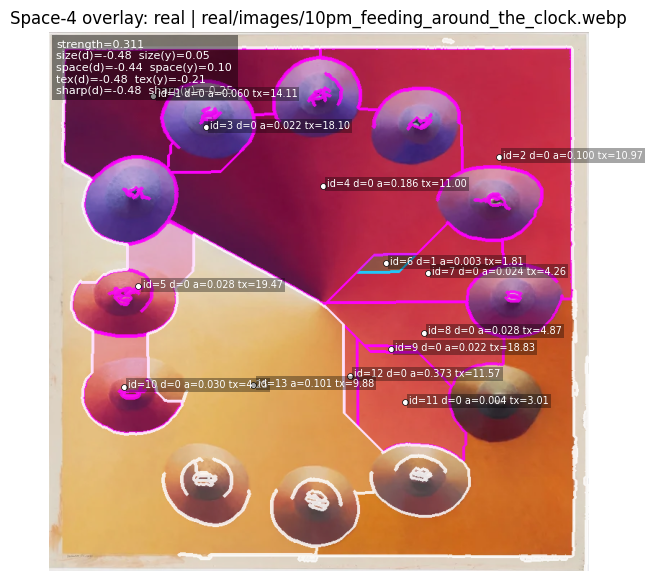

,split,image_id,region_id,area_ratio,centroid_x,centroid_y,centroid_y_norm,depth_rank,tex_energy,sharpness_lap_var,__priority__
4,real,real/images/10pm_feeding_around_the_clock.webp,5,0.027751,124.510232,353.052088,0.471995,0.0,19.465204,1280.319702,0.663898
8,real,real/images/10pm_feeding_around_the_clock.webp,9,0.021693,104.449860,492.320204,0.658182,0.0,18.827641,1073.140625,0.495414
2,real,real/images/10pm_feeding_around_the_clock.webp,3,0.022165,218.272187,132.192515,0.176728,0.0,18.095284,677.642090,0.377982
9,real,real/images/10pm_feeding_around_the_clock.webp,10,0.029609,494.345999,514.028678,0.687204,0.0,4.247437,79.789047,0.111958
6,real,real/images/10pm_feeding_around_the_clock.webp,7,0.024037,526.679553,334.182404,0.446768,0.0,4.259059,81.195663,0.057890
11,real,real/images/10pm_feeding_around_the_clock.webp,12,0.372717,284.339507,489.889604,0.654933,0.0,11.571482,1858.772461,-0.010426
7,real,real/images/10pm_feeding_around_the_clock.webp,8,0.027541,520.728848,417.181759,0.557730,0.0,4.872148,87.851738,-0.010906
0,real,real/images/10pm_feeding_around_the_clock.webp,1,0.060064,145.040307,87.750837,0.117314,0.0,14.105822,1939.047241,-0.041790
5,real,real/images/10pm_feeding_around_the_clock.webp,6,0.002538,468.500000,321.000000,0.429144,1.0,1.810859,14.844036,-0.093576
10,real,real/images/10pm_feeding_around_the_clock.webp,11,0.004174,418.455437,477.018763,0.637726,0.0,3.006702,20.100740,-0.169757


In [51]:
annotate_space4_for_image(
    split="real",
    image_id="real/images/10pm_feeding_around_the_clock.webp",
    df_space4_regions=df_space4_regions,
    df_space4_indices=df_space4_indices,
    topk_regions=14,
    save_dir=SPACE_DIR / "debug_space4_single",
    show=True
)

Saved: outputs\space\debug_space4_single\space4_real_real_images_Pregnancy_in_three_acts.webp.png


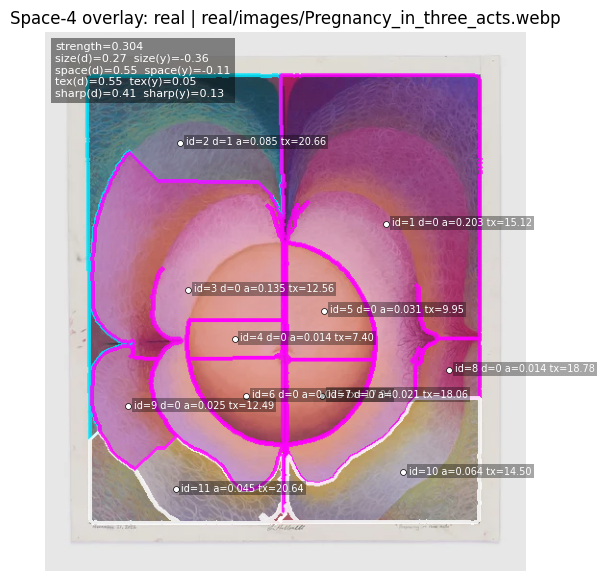

,split,image_id,region_id,area_ratio,centroid_x,centroid_y,centroid_y_norm,depth_rank,tex_energy,sharpness_lap_var,__priority__
1090,real,real/images/Pregnancy_in_three_acts.webp,4,0.013715,196.736938,319.151547,0.569913,0.0,7.398398,158.555634,0.819677
1088,real,real/images/Pregnancy_in_three_acts.webp,2,0.084674,140.027157,115.028841,0.205409,1.0,20.658140,4274.229980,0.672867
1097,real,real/images/Pregnancy_in_three_acts.webp,11,0.045323,135.401086,475.646661,0.849369,NaN,20.636415,4169.429688,0.511404
1091,real,real/images/Pregnancy_in_three_acts.webp,5,0.031176,290.159748,289.482333,0.516933,0.0,9.953917,234.903931,0.411695
1089,real,real/images/Pregnancy_in_three_acts.webp,3,0.135430,148.408445,267.825945,0.478261,0.0,12.561315,686.641663,0.153163
1094,real,real/images/Pregnancy_in_three_acts.webp,8,0.013665,420.115575,351.259588,0.627249,0.0,18.781254,1686.352417,-0.233546
1095,real,real/images/Pregnancy_in_three_acts.webp,9,0.024813,85.954885,389.154741,0.694919,0.0,12.491498,836.504028,-0.254355
1092,real,real/images/Pregnancy_in_three_acts.webp,6,0.024570,208.457632,378.561811,0.676003,0.0,17.942354,5581.739746,-0.288189
1093,real,real/images/Pregnancy_in_three_acts.webp,7,0.021447,287.938996,377.886802,0.674798,0.0,18.063562,588.175720,-0.293086
1087,real,real/images/Pregnancy_in_three_acts.webp,1,0.202891,354.428986,199.050131,0.355447,0.0,15.119884,3247.895020,-0.359793


In [52]:
annotate_space4_for_image(
    split="real",
    image_id="real/images/Pregnancy_in_three_acts.webp",
    df_space4_regions=df_space4_regions,
    df_space4_indices=df_space4_indices,
    topk_regions=14,
    save_dir=SPACE_DIR / "debug_space4_single",
    show=True
)

### Perspective & Vanishing Structure

In [72]:
SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

CANNY_LOW  = 40
CANNY_HIGH = 140

HOUGH_THRESHOLD = 60
MIN_LINE_LEN    = 45
MAX_LINE_GAP    = 8

MIN_ABS_SLOPE = 0.15   # remove near-horizontal noise
MAX_ABS_SLOPE = 20.0

RANSAC_ITERS   = 800
INLIER_RAD_PX  = 25.0
MIN_INLIERS    = 10

N_RINGS = 10

### Helpers

In [73]:
def ensure_gray_u8(gray):
    if gray.dtype == np.uint8:
        return gray
    return (np.clip(gray, 0, 1) * 255).astype(np.uint8)


def line_to_abc(x1,y1,x2,y2):
    a = y1 - y2
    b = x2 - x1
    c = x1*y2 - x2*y1
    n = math.hypot(a, b) + 1e-9
    return (a/n, b/n, c/n)


def intersect_lines(L1, L2):
    a1,b1,c1 = L1
    a2,b2,c2 = L2
    det = a1*b2 - a2*b1
    if abs(det) < 1e-9:
        return None
    x = (b1*c2 - b2*c1) / det
    y = (c1*a2 - c2*a1) / det
    return (x, y)


def detect_line_segments(gray_u8):
    edges = cv2.Canny(gray_u8, CANNY_LOW, CANNY_HIGH)
    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180, HOUGH_THRESHOLD,
        minLineLength=MIN_LINE_LEN, maxLineGap=MAX_LINE_GAP
    )

    segs = []
    if lines is None:
        return segs

    for l in lines[:,0,:]:
        x1,y1,x2,y2 = map(int, l)
        dx = x2 - x1
        dy = y2 - y1
        slope = abs(dy / (dx + 1e-9))
        if not (MIN_ABS_SLOPE <= slope <= MAX_ABS_SLOPE):
            continue
        length = float(np.hypot(dx, dy))
        angle  = float(math.atan2(dy, dx))
        segs.append((x1,y1,x2,y2,length,angle))

    segs.sort(key=lambda t: t[4], reverse=True)
    return segs[:250]


def all_intersections(segs, W, H):
    lines = [line_to_abc(*s[:4]) for s in segs]
    pts = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            p = intersect_lines(lines[i], lines[j])
            if p is None:
                continue
            x,y = p
            if -0.5*W <= x <= 1.5*W and -0.5*H <= y <= 1.5*H:
                pts.append(p)
    return np.array(pts, float)


def ransac_vp(points):
    if len(points) == 0:
        return None, 0, None

    best_p, best_n, best_mask = None, 0, None
    for _ in range(RANSAC_ITERS):
        p = points[np.random.randint(len(points))]
        d = np.hypot(points[:,0]-p[0], points[:,1]-p[1])
        mask = d <= INLIER_RAD_PX
        n = int(mask.sum())
        if n > best_n:
            best_n, best_p, best_mask = n, p, mask

    if best_n < MIN_INLIERS:
        return None, best_n, None

    vp = points[best_mask].mean(axis=0)
    return (float(vp[0]), float(vp[1])), best_n, best_mask


def convergence_strength(inliers):
    if inliers is None or len(inliers) < 5:
        return 0.0, np.nan
    var = float(np.mean(np.sum((inliers - inliers.mean(0))**2, axis=1)))
    score = float(np.exp(-var / (2*(INLIER_RAD_PX**2))))
    return score, var


def vp_eccentricity(vp, W, H):
    cx, cy = W/2, H/2
    return float(np.hypot(vp[0]-cx, vp[1]-cy) / (0.5*np.hypot(W,H)))

In [74]:
def angle_wrap_pi(a):
    """wrap to [-pi/2, +pi/2] for undirected line angles"""
    a = ((a + np.pi/2) % np.pi) - np.pi/2
    return a

def segment_midpoint(seg):
    x1,y1,x2,y2 = seg[:4]
    return np.array([(x1+x2)*0.5, (y1+y2)*0.5], dtype=float)

def point_line_signed_dist(p, seg):
    """signed perpendicular distance from point p=(x,y) to segment's infinite line"""
    x1,y1,x2,y2 = map(float, seg[:4])
    px,py = float(p[0]), float(p[1])
    # line through (x1,y1)-(x2,y2)
    A = y1 - y2
    B = x2 - x1
    C = x1*y2 - x2*y1
    n = math.hypot(A,B) + 1e-9
    return (A*px + B*py + C) / n

def compression_curve_from_vp(segs, vp, angle_bin_deg=10, min_pairs=12):
    """
    Measures 'spacing decay toward VP' using bands of similarly-oriented lines.
    Returns: (corr, strength, slope_like)
      corr: Spearman corr between spacing and distance-to-VP (expect negative)
      strength: mapped to [0,1], higher => stronger compression
      slope_like: rough linear slope of spacing vs distance (optional, for reporting)
    """
    if vp is None or len(segs) < 6:
        return np.nan, np.nan, np.nan

    vp = np.array(vp, dtype=float)

    # group segments by undirected angle bin
    angs = np.array([angle_wrap_pi(s[5]) for s in segs], dtype=float)  # use stored angle_rad
    bin_w = np.deg2rad(angle_bin_deg)
    bins = np.floor((angs + np.pi/2) / bin_w).astype(int)

    all_d = []
    all_s = []

    # within each bin, compute pairwise spacing between lines + avg distance to VP
    for b in np.unique(bins):
        idx = np.where(bins == b)[0]
        if len(idx) < 3:
            continue

        segs_b = [segs[i] for i in idx]
        # precompute midpoints and their distances to VP
        mids = np.array([segment_midpoint(s) for s in segs_b], dtype=float)
        d_to_vp = np.linalg.norm(mids - vp[None, :], axis=1)

        # compute spacing between every pair as distance between the two infinite lines
        # (using midpoint of one line plugged into the other line distance)
        for i in range(len(segs_b)):
            for j in range(i+1, len(segs_b)):
                si = segs_b[i]
                sj = segs_b[j]

                # symmetric line-to-line spacing estimate
                di = abs(point_line_signed_dist(mids[i], sj))
                dj = abs(point_line_signed_dist(mids[j], si))
                spacing = 0.5 * (di + dj)

                # pair distance-to-vp as average of the two mid distances
                d_pair = 0.5 * (d_to_vp[i] + d_to_vp[j])

                # ignore degenerate tiny spacings
                if spacing > 1e-6 and np.isfinite(d_pair):
                    all_d.append(d_pair)
                    all_s.append(spacing)

    if len(all_d) < min_pairs:
        return np.nan, np.nan, np.nan

    all_d = np.asarray(all_d, float)
    all_s = np.asarray(all_s, float)

    # Spearman captures monotonic decay, robust to outliers
    corr, _ = spearmanr(all_d, all_s)
    if not np.isfinite(corr):
        return np.nan, np.nan, np.nan

    # If compression exists, spacing should DECREASE as distance-to-VP DECREASES:
    # closer to VP => smaller spacing => spacing increases with distance => corr should be POSITIVE.
    # BUT depending on definition (distance outward vs inward), sign can flip.
    #
    # We'll define compression as: spacing is SMALL near VP.
    # If d_to_vp is small near VP, then spacing should be small when d is small => corr tends to positive.
    #
    # So "compression strength" should use +corr (not negative).
    strength = float(np.clip((corr + 1) / 2, 0, 1))

    # quick slope-like estimate (for reporting only)
    # spacing ≈ a*d + b
    a = float(np.polyfit(all_d, all_s, 1)[0]) if len(all_d) >= 2 else np.nan

    return float(corr), strength, a

### Batch Computation

In [76]:
rows_lines = []
rows_idx   = []

for _, m in df_manifest.iterrows():
    split, image_id = m["split"], m["image_id"]
    rgb  = ensure_rgb01(imread_rgb(DATA_DIR / image_id))
    gray = to_gray(rgb)
    gray_u8 = ensure_gray_u8(gray)
    H, W = gray_u8.shape

    segs = detect_line_segments(gray_u8)
    inters = all_intersections(segs, W, H)
    vp, nin, mask = ransac_vp(inters)

    if vp is not None:
        inliers = inters[mask]
        conv_score, conv_var = convergence_strength(inliers)
        ecc = vp_eccentricity(vp, W, H)

        comp_corr, comp_strength, comp_slope = compression_curve_from_vp(segs, vp)

        # combine (keep your old definition, just add compression as a 3rd term)
        # weights are interpretable and easy to justify
        strength = float(np.clip(0.45*conv_score + 0.25*ecc + 0.30*(comp_strength if np.isfinite(comp_strength) else 0.0), 0, 1))
    else:
        conv_score = conv_var = ecc = strength = np.nan
        comp_corr = comp_strength = comp_slope = np.nan

    for i,s in enumerate(segs):
        rows_lines.append({
            "split": split, "image_id": image_id,
            "line_id": i,
            "x1": s[0], "y1": s[1], "x2": s[2], "y2": s[3],
            "length_px": s[4], "angle_rad": s[5]
        })

    rows_idx.append({
        "split": split, "image_id": image_id,
        "space5_n_lines": len(segs),
        "space5_n_inters": len(inters),
        "space5_vp_x": vp[0] if vp else np.nan,
        "space5_vp_y": vp[1] if vp else np.nan,
        "space5_inliers": nin,
        "space5_convergence_score": conv_score,
        "space5_convergence_var": conv_var,
        "space5_vp_eccentricity": ecc,
        "space5_perspective_strength": strength,
        "space5_compression_corr": comp_corr,
        "space5_compression_strength": comp_strength,
        "space5_compression_slope": comp_slope
    })

In [77]:
df_lines = pd.DataFrame(rows_lines)
df_idx   = pd.DataFrame(rows_idx)

df_lines.to_csv(SPACE_DIR / "space5_lines.csv", index=False)
df_idx.to_csv(SPACE_DIR / "space5_indices.csv", index=False)

print("Saved:", SPACE_DIR / "space5_lines.csv", SPACE_DIR / "space5_indices.csv")
display(df_idx.head())

Saved: outputs\space\space5_lines.csv outputs\space\space5_indices.csv


,split,image_id,space5_n_lines,space5_n_inters,space5_vp_x,space5_vp_y,space5_inliers,space5_convergence_score,space5_convergence_var,space5_vp_eccentricity,space5_perspective_strength,space5_compression_corr,space5_compression_strength,space5_compression_slope
0,real,real/images/10pm_feeding_around_the_clock.webp,3,3,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,real,real/images/11pm.webp,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,real,real/images/12_4_7_10.webp,15,96,373.755647,374.49205,68,0.944757,71.034673,0.002348,0.542945,-0.218548,0.390726,-0.131351
3,real,real/images/around_the_clock.webp,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,real,real/images/around_the_clock_alizarin.webp,6,11,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visual Verification

In [80]:
def annotate_space5(split, image_id, vp, segs, save_dir=None, show=True):
    rgb = ensure_rgb01(imread_rgb(DATA_DIR / image_id))
    H, W = rgb.shape[:2]
    canvas = (rgb*255).astype(np.uint8)

    for (x1,y1,x2,y2,_,_) in segs:
        cv2.line(canvas, (x1,y1), (x2,y2), (255,0,255), 1)

    if vp is not None:
        vx, vy = int(vp[0]), int(vp[1])
        for rr in np.linspace(40, min(W,H)*0.45, 6):
            cv2.circle(canvas, (vx, vy), int(rr), (0,255,255), 1)
        for s in segs[:25]:
            mx = int((s[0]+s[2])*0.5)
            my = int((s[1]+s[3])*0.5)
            cv2.line(canvas, (mx,my), (vx,vy), (0,255,255), 1)

    plt.figure(figsize=(7,7))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title(f"Space-5 overlay | {split} | {image_id}")

    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_dir / f"space5_{split}_{image_id.replace('/','_')}.png", dpi=160)

    if show: plt.show()
    else: plt.close()

In [81]:
DEBUG_DIR = SPACE_DIR / "debug_space5"
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

top = df_idx.sort_values("space5_perspective_strength", ascending=False).head(15)
for _, r in top.iterrows():
    rgb = ensure_rgb01(imread_rgb(DATA_DIR / r["image_id"]))
    gray = to_gray(rgb)
    segs = detect_line_segments(ensure_gray_u8(gray))
    vp = (r["space5_vp_x"], r["space5_vp_y"]) if np.isfinite(r["space5_vp_x"]) else None
    annotate_space5(r["split"], r["image_id"], vp, segs, save_dir=DEBUG_DIR, show=False)

In [82]:
df_vp = df_idx[
    df_idx["space5_perspective_strength"].notna()
].sort_values("space5_perspective_strength", ascending=False)

df_vp[[
    "split",
    "image_id",
    "space5_n_lines",
    "space5_inliers",
    "space5_perspective_strength"
]]

,split,image_id,space5_n_lines,space5_inliers,space5_perspective_strength
81,generated,generated/ComfyUI_00098_.png,16,18,0.784853
118,generated,generated/ComfyUI_00150_.png,75,206,0.764137
38,real,real/images/Linked_Lingam_Orange.webp,250,374,0.764099
14,real,real/images/Book_of_Birth_2.webp,32,38,0.755932
37,real,real/images/Lingam_Twist_Blue_Orange.webp,36,19,0.739931
26,real,real/images/Finding_Time.webp,57,42,0.732582
39,real,real/images/Linked_Lingams_Yellow_Purple.webp,135,826,0.692191
16,real,real/images/Colostrum_well.webp,26,68,0.688639
41,real,real/images/Meeting_in_the_middle.webp,250,698,0.681617
18,real,real/images/Deep_Tear.webp,18,39,0.665630


Image: real/images/Expanding_Figure.webp
Lines: 9 Intersections: 36 Inliers: 18
VP: (240.19749651005057, 262.25860347287045)


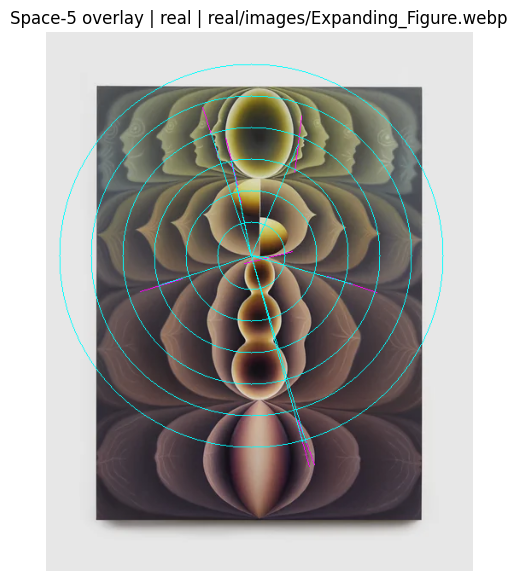

In [90]:
# ---- Visualize ONE Space-5 example in notebook ----

row = df_vp.iloc[33]   # strongest perspective image

split = row["split"]
image_id = row["image_id"]

# reload image
rgb = ensure_rgb01(imread_rgb(DATA_DIR / image_id))
gray = to_gray(rgb)
gray_u8 = ensure_gray_u8(gray)

# recompute lines + intersections (same as batch)
segs = detect_line_segments(gray_u8)
inters = all_intersections(segs, rgb.shape[1], rgb.shape[0])
vp, nin, mask = ransac_vp(inters)

print("Image:", image_id)
print("Lines:", len(segs), "Intersections:", len(inters), "Inliers:", nin)
print("VP:", vp)

# show overlay
annotate_space5(
    split=split,
    image_id=image_id,
    vp=vp,
    segs=segs,
    save_dir=None,   # no saving yet
    show=True
)

In [84]:
SPACE5_DEBUG_DIR = SPACE_DIR / "debug_space5"
SPACE5_DEBUG_DIR.mkdir(parents=True, exist_ok=True)

for _, r in df_vp.head(10).iterrows():
    rgb = ensure_rgb01(imread_rgb(DATA_DIR / r["image_id"]))
    gray = to_gray(rgb)
    segs = detect_line_segments(ensure_gray_u8(gray))
    vp = (r["space5_vp_x"], r["space5_vp_y"])

    annotate_space5(
        split=r["split"],
        image_id=r["image_id"],
        vp=vp,
        segs=segs,
        save_dir=SPACE5_DEBUG_DIR,
        show=False
    )

print("Saved Space-5 overlays to:", SPACE5_DEBUG_DIR)

Saved Space-5 overlays to: outputs\space\debug_space5


### Frame / Window Effects

In [91]:
SPACE_DIR = OUT_DIR / "space"
SPACE_DIR.mkdir(parents=True, exist_ok=True)

In [92]:
FRAME_BAND_PX = 10          # thickness of "frame zone" used for contact + near-frame tests
SAL_PERC_STRONG = 80        # threshold for "salient" regions (percentile of saliency mean)
MIN_REGION_AREA_RATIO = 0.002
EDGE_PERCENTILE = 80

### Helper Functions

In [93]:
def ensure_rgb01(rgb):
    rgb = rgb.astype(np.float32)
    if rgb.max() > 1.5:
        rgb = rgb / 255.0
    return np.clip(rgb, 0, 1)

def frame_band_mask(H, W, band=FRAME_BAND_PX):
    m = np.zeros((H, W), dtype=bool)
    b = int(band)
    if b <= 0:
        return m
    m[:b, :] = True
    m[-b:, :] = True
    m[:, :b] = True
    m[:, -b:] = True
    return m

def strong_contour_mask(gray01, pct=EDGE_PERCENTILE):
    """
    Uses gradient magnitude -> "strong contour" pixels.
    More stable than relying on raw Canny thresholds across paintings.
    """
    g = (np.clip(gray01, 0, 1) * 255).astype(np.uint8)
    gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx*gx + gy*gy)
    thr = np.percentile(mag, pct) if np.isfinite(mag).any() else 0.0
    return (mag >= thr)

def region_touches_frame(mask_bool, band_mask):
    return bool((mask_bool & band_mask).any())

def region_touch_ratio(mask_bool, band_mask):
    # how much of region area lies in frame band (proxy for truncation)
    a = float(mask_bool.sum()) + 1e-9
    return float((mask_bool & band_mask).sum() / a)

def mean_on_mask(x, m):
    if m.sum() == 0:
        return np.nan
    return float(np.mean(x[m]))

#### Batch Run

In [95]:
rows_regions = []
rows_idx = []

for _, m in df_manifest.iterrows():
    split, image_id = m["split"], m["image_id"]
    path = DATA_DIR / image_id

    rgb = ensure_rgb01(imread_rgb(path))
    gray = to_gray(rgb)  # assumed 0..1 float
    H, W = gray.shape

    # segmentation (must match your pipeline)
    edges = edge_map_multiscale(gray)
    labels = region_map_from_edges(gray, edges)
    min_area_px = int(MIN_REGION_AREA_RATIO * H * W)
    labels = filter_small_regions(labels, min_area_px=min_area_px)

    # saliency
    sal01 = saliency_map(gray)

    band = frame_band_mask(H, W, FRAME_BAND_PX)

    # 1) Frame contact ratio: strong contours touching boundary band
    strong_edges = strong_contour_mask(gray, pct=EDGE_PERCENTILE)
    denom_edges = float(strong_edges.sum()) + 1e-9
    frame_contact_ratio = float((strong_edges & band).sum() / denom_edges)

    # per-region stats
    region_ids = np.unique(labels)
    region_ids = region_ids[region_ids != 0]

    if len(region_ids) == 0:
        rows_idx.append({
            "split": split, "image_id": image_id,
            "space6_n_regions": 0,
            "space6_frame_contact_ratio": frame_contact_ratio,
            "space6_border_dominance_inside": np.nan,
            "space6_cropping_tension": 0.0,
            "space6_n_truncated_salient": 0,
            "space6_frame_effect_strength": 0.0
        })
        continue

    # border/inside dominance proxy: are boundary-touching regions "figure-like"?
    # We reuse a simple, local fig proxy: mean saliency of region, normalized per image.
    sal_mean = {}
    touches = {}
    touch_ratio = {}

    for rid in region_ids:
        mask = (labels == rid)
        sal_mean[int(rid)] = mean_on_mask(sal01, mask)
        touches[int(rid)] = region_touches_frame(mask, band)
        touch_ratio[int(rid)] = region_touch_ratio(mask, band)

    # normalize saliency within image -> fig proxy in [0,1]
    vals = np.array([sal_mean[r] for r in sal_mean.keys()], float)
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        # degenerate
        fig_prob = {r: 0.0 for r in sal_mean.keys()}
        sal_thr = 1.0
    else:
        lo, hi = float(np.percentile(vals, 5)), float(np.percentile(vals, 95))
        hi = hi if hi > lo + 1e-6 else lo + 1e-6
        fig_prob = {r: float(np.clip((sal_mean[r] - lo) / (hi - lo), 0, 1))
                    for r in sal_mean.keys()}
        sal_thr = float(np.percentile(vals, SAL_PERC_STRONG))

    # 2) Border dominance near frame (proxy)
    # If boundary-touching regions tend to have high fig_prob -> "inside dominates at frame"
    bt = [r for r in region_ids if touches[int(r)]]
    if len(bt) > 0:
        w = np.array([touch_ratio[int(r)] for r in bt], float)
        w = w / (w.sum() + 1e-9)
        border_dom_inside = float(np.sum([fig_prob[int(r)] * w[i] for i, r in enumerate(bt)]))
    else:
        border_dom_inside = np.nan

    # 3) Cropping tension: salient forms truncated by frame
    truncated_salient = []
    cropping_tension = 0.0

    for rid in region_ids:
        rid = int(rid)
        if not touches[rid]:
            continue
        # salient region (relative to image)
        if not np.isfinite(sal_mean[rid]):
            continue
        if sal_mean[rid] < sal_thr:
            continue
        # weight by (a) how much it sits in the frame band and (b) its fig_prob
        t = float(fig_prob[rid] * touch_ratio[rid])
        if t > 0:
            truncated_salient.append(rid)
            cropping_tension += t

        rows_regions.append({
            "split": split, "image_id": image_id,
            "region_id": rid,
            "touch_ratio": float(touch_ratio[rid]),
            "sal_mean": float(sal_mean[rid]),
            "fig_prob": float(fig_prob[rid]),
            "is_truncated_salient": int(rid in truncated_salient)
        })

    n_trunc = int(len(truncated_salient))
    cropping_tension = float(cropping_tension)

    # Combine into a single Space-6 strength (interpretable, bounded-ish)
    # - more edge contact + more salient truncation + stronger inside-dominance => stronger frame effect
    bd = 0.0 if not np.isfinite(border_dom_inside) else float(border_dom_inside)
    strength = float(np.clip(0.45*frame_contact_ratio + 0.40*cropping_tension + 0.15*bd, 0, 1))

    rows_idx.append({
        "split": split, "image_id": image_id,
        "space6_n_regions": int(len(region_ids)),
        "space6_frame_contact_ratio": frame_contact_ratio,
        "space6_border_dominance_inside": border_dom_inside,
        "space6_cropping_tension": cropping_tension,
        "space6_n_truncated_salient": n_trunc,
        "space6_frame_effect_strength": strength
    })

In [97]:
df_space6_regions = pd.DataFrame(rows_regions)
df_space6_idx = pd.DataFrame(rows_idx)

df_space6_regions.to_csv(SPACE_DIR / "space6_regions.csv", index=False)
df_space6_idx.to_csv(SPACE_DIR / "space6_indices.csv", index=False)

print("Saved:", SPACE_DIR / "space6_regions.csv", SPACE_DIR / "space6_indices.csv")
print("regions:", df_space6_regions.shape, "indices:", df_space6_idx.shape)
display(df_space6_idx.head())

Saved: outputs\space\space6_regions.csv outputs\space\space6_indices.csv
regions: (92, 7) indices: (130, 8)


,split,image_id,space6_n_regions,space6_frame_contact_ratio,space6_border_dominance_inside,space6_cropping_tension,space6_n_truncated_salient,space6_frame_effect_strength
0,real,real/images/10pm_feeding_around_the_clock.webp,22,0.095620,0.549088,0.288532,1,0.240805
1,real,real/images/11pm.webp,40,0.021693,1.000000,0.209716,1,0.243648
2,real,real/images/12_4_7_10.webp,14,0.000000,NaN,0.000000,0,0.000000
3,real,real/images/around_the_clock.webp,19,0.000000,NaN,0.000000,0,0.000000
4,real,real/images/around_the_clock_alizarin.webp,9,0.009057,NaN,0.000000,0,0.004076


### Visual Verification

In [98]:
def overlay_fill(rgb01, mask, color=(1, 0, 0), alpha=0.35):
    out = rgb01.copy()
    if mask is None or mask.sum() == 0:
        return out
    m = mask.astype(bool)
    out[m, 0] = (1-alpha)*out[m, 0] + alpha*color[0]
    out[m, 1] = (1-alpha)*out[m, 1] + alpha*color[1]
    out[m, 2] = (1-alpha)*out[m, 2] + alpha*color[2]
    return out

def annotate_space6(split, image_id, df_space6_idx, df_space6_regions,
                    band_px=FRAME_BAND_PX, save_dir=None, show=True, figsize=(7,7)):

    rgb = ensure_rgb01(imread_rgb(DATA_DIR / image_id))
    gray = to_gray(rgb)
    H, W = gray.shape

    edges = edge_map_multiscale(gray)
    labels = region_map_from_edges(gray, edges)
    labels = filter_small_regions(labels, min_area_px=int(MIN_REGION_AREA_RATIO * H * W))

    sal01 = saliency_map(gray)
    band = frame_band_mask(H, W, band_px)

    # strong contour pixels that touch frame band
    strong_edges = strong_contour_mask(gray, pct=EDGE_PERCENTILE)
    frame_edges = strong_edges & band

    base = rgb.copy()

    # show frame band lightly
    base = overlay_fill(base, band, color=(0.2, 0.9, 1.0), alpha=0.10)  # cyan tint

    # show strong contours on frame
    base = overlay_fill(base, frame_edges, color=(1.0, 0.0, 0.0), alpha=0.75)  # red

    # find truncated salient regions from df_space6_regions
    dfR = df_space6_regions[(df_space6_regions["split"] == split) &
                            (df_space6_regions["image_id"] == image_id) &
                            (df_space6_regions["is_truncated_salient"] == 1)].copy()

    # fill them (yellow)
    for rid in dfR["region_id"].astype(int).tolist():
        base = overlay_fill(base, labels == rid, color=(1.0, 1.0, 0.0), alpha=0.25)

        # label at centroid
        ys, xs = np.where(labels == rid)
        if len(xs) > 0:
            cx, cy = int(np.mean(xs)), int(np.mean(ys))
            cv2.circle((base*255).astype(np.uint8), (cx,cy), 3, (255,255,255), -1)

    # metrics box
    row = df_space6_idx[(df_space6_idx["split"] == split) & (df_space6_idx["image_id"] == image_id)]
    if row.empty:
        txt = "No Space-6 row found"
    else:
        r = row.iloc[0]
        txt = (
            f"strength={r['space6_frame_effect_strength']:.3f}\n"
            f"frame_contact={r['space6_frame_contact_ratio']:.3f}\n"
            f"border_dom_in={r['space6_border_dominance_inside'] if np.isfinite(r['space6_border_dominance_inside']) else np.nan:.3f}\n"
            f"crop_tension={r['space6_cropping_tension']:.3f}\n"
            f"n_trunc_sal={int(r['space6_n_truncated_salient'])}"
        )

    plt.figure(figsize=figsize)
    plt.imshow(base)
    plt.axis("off")
    plt.title(f"Space-6 overlay | {split} | {image_id}")
    plt.text(
        10, 12, txt, fontsize=9, color="white",
        bbox=dict(facecolor="black", alpha=0.45, edgecolor="none", pad=3)
    )

    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        safe = image_id.replace("/", "_").replace("\\", "_")
        out_path = save_dir / f"space6_{split}_{safe}.png"
        plt.savefig(out_path, dpi=160, bbox_inches="tight")
        print("Saved:", out_path)

    if show:
        plt.show()
    else:
        plt.close()

In [99]:
DEBUG_SPACE6 = SPACE_DIR / "debug_space6"
DEBUG_SPACE6.mkdir(parents=True, exist_ok=True)

top6 = df_space6_idx.sort_values("space6_frame_effect_strength", ascending=False).head(15)
for _, r in top6.iterrows():
    annotate_space6(r["split"], r["image_id"], df_space6_idx, df_space6_regions,
                    save_dir=DEBUG_SPACE6, show=False)

print("Saved Space-6 overlays to:", DEBUG_SPACE6)

Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00110_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00132_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00151_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00149_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00139_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00103_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00096_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00129_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00105_.png.png
Saved: outputs\space\debug_space6\space6_generated_generated_ComfyUI_00152_.png.png
Saved: outputs\space\debug_space6\space6_real_real_images_Belly_breast.webp.png
Saved: outputs\space\debug_space6\space6_real_real_images_Blue_Nip.webp.png
Save

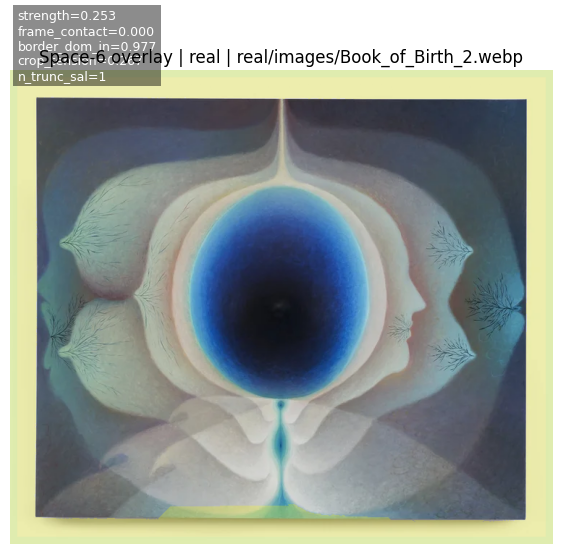

In [105]:
row = df_space6_idx.sort_values("space6_frame_effect_strength", ascending=False).iloc[12]
annotate_space6(row["split"], row["image_id"], df_space6_idx, df_space6_regions,
                save_dir=None, show=True)